In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from fashion_mnist.utils.mnist_reader import load_mnist

In [3]:
total_train_image, total_train_labels = load_mnist('./fashion_mnist/data/fashion/', kind='train')
test_image, test_labels = load_mnist('./fashion_mnist/data/fashion/', kind='t10k')

In [4]:
train_image, validation_image = train_test_split(total_train_image, test_size=0.15, random_state=0)
train_labels, validation_labels = train_test_split(total_train_labels, test_size=0.15, random_state=0)

In [5]:
train_labels_onehot = pd.get_dummies(train_labels)
validation_labels_onehot = pd.get_dummies(validation_labels)
test_labels_onehot = pd.get_dummies(test_labels)

In [6]:
def softmax(z):
    exp_num = tf.exp(z)
    sum_div = tf.reduce_sum(exp_num,1, keepdims=True)
    return exp_num / sum_div

def sigmoid(z):
    return 1 / (1 + tf.exp(-z))    

def cross_entropy(y, h):
    return tf.reduce_mean(tf.reduce_sum(-tf.log(h)*y,1, keepdims=True))

In [7]:
lr = 0.000001
hidden = 2**8
batch = train_image.shape[0]
epochs = 10000
iterations = int(train_image.shape[0]/batch)

In [8]:
2**4

16

In [9]:
#plt.imshow(test_image[30].reshape(28,28))

In [10]:
x_ori = tf.placeholder(tf.float32, shape =([None,28*28]))
X = tf.concat([tf.ones((tf.shape(x_ori)[0],1),dtype=tf.float32),x_ori],axis=1)

y = tf.placeholder(tf.float32, shape =([None, 10]))

In [11]:
theta1 = tf.get_variable("theta1", shape=(28*28+1,hidden), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())

In [12]:
gradient1 = tf.get_variable("gradient1", shape=(28*28+1,hidden), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())

In [13]:
theta2 = tf.get_variable("theta2", shape=(hidden+1,10), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())

In [14]:
gradient2 = tf.get_variable("gradient2", shape=(hidden+1,10), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())

In [15]:
z1 = tf.matmul(X, theta1)
h1_ori = sigmoid(z1)
h1 = tf.concat([tf.ones((tf.shape(x_ori)[0],1),dtype=tf.float32),h1_ori],axis=1)

In [16]:
z2 = tf.matmul(h1, theta2)
h2 = softmax(z2)

In [17]:
gradient2_update = gradient2.assign(tf.tensordot(tf.transpose(h1), tf.subtract(h2, y),1))

In [18]:
theta2_update = theta2.assign(theta2 - lr * gradient2)

In [19]:
dE_dz2 = h2-y

In [20]:
dE_dh1 = tf.matmul(dE_dz2 , tf.transpose(theta2[1:,:]))

In [21]:
dE_dz1 = tf.multiply(dE_dh1,tf.multiply(h1_ori,tf.subtract(tf.ones_like(h1_ori),h1_ori)))

In [22]:
gradient1_update = gradient1.assign(tf.matmul(tf.transpose(X), dE_dz1))

In [23]:
theta1_update = theta1.assign(theta1 - lr * gradient1)

In [24]:
loss = cross_entropy(y,h2)

In [25]:
tf_X = tf.placeholder(tf.float32)
tf_X_norm = tf.image.per_image_standardization(tf_X)

In [26]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

train_image_norm = sess.run(tf_X_norm, feed_dict={tf_X: train_image})
validation_image_norm = sess.run(tf_X_norm, feed_dict={tf_X: validation_image})
test_image_norm = sess.run(tf_X_norm, feed_dict={tf_X: test_image})

In [27]:
sess.run(tf.global_variables_initializer())

train_epoch_loss_list = []
validation_epoch_loss_list = []

for i in range(epochs):
    batch_accumulate_loss = 0
    
    print('Epoch {}'.format(i))
    for j in range(iterations):
        index = j*batch
        values = sess.run([gradient2_update,theta2_update,gradient1_update, theta1_update, loss], feed_dict={x_ori:train_image_norm[index:index+batch], y:train_labels_onehot[index:index+batch]})
        
        batch_accumulate_loss += values[-1]

    train_epoch_loss = batch_accumulate_loss/iterations
    train_epoch_loss_list.append(train_epoch_loss)
    validation_epoch_loss = sess.run(loss, feed_dict={x_ori:validation_image_norm, y:validation_labels_onehot})
    validation_epoch_loss_list.append(validation_epoch_loss)

    print('Training loss:')
    print(train_epoch_loss)
    print('Validation loss:')
    print(validation_epoch_loss)

Epoch 0
Iteration loss:
2.7295141220092773
Validation loss:
2.738817
Epoch 1
Iteration loss:
2.4277660846710205
Validation loss:
2.4334826
Epoch 2
Iteration loss:
2.2472341060638428
Validation loss:
2.250924
Epoch 3
Iteration loss:
2.120753765106201
Validation loss:
2.1232684
Epoch 4
Iteration loss:
2.02536678314209
Validation loss:
2.0271797
Epoch 5
Iteration loss:
1.9476794004440308
Validation loss:
1.9490707
Epoch 6
Iteration loss:
1.8805404901504517
Validation loss:
1.8816881
Epoch 7
Iteration loss:
1.820488691329956
Validation loss:
1.8215096
Epoch 8
Iteration loss:
1.7658768892288208
Validation loss:
1.7668463
Epoch 9
Iteration loss:
1.7158242464065552
Validation loss:
1.7167901
Epoch 10
Iteration loss:
1.6697579622268677
Validation loss:
1.67075
Epoch 11
Iteration loss:
1.6272392272949219
Validation loss:
1.6282747
Epoch 12
Iteration loss:
1.5879007577896118
Validation loss:
1.5889883
Epoch 13
Iteration loss:
1.551422357559204
Validation loss:
1.552566
Epoch 14
Iteration loss:
1

Iteration loss:
0.7752009034156799
Validation loss:
0.7756067
Epoch 117
Iteration loss:
0.7733585834503174
Validation loss:
0.77374655
Epoch 118
Iteration loss:
0.7715399861335754
Validation loss:
0.7719101
Epoch 119
Iteration loss:
0.769744336605072
Validation loss:
0.7700968
Epoch 120
Iteration loss:
0.7679715156555176
Validation loss:
0.7683063
Epoch 121
Iteration loss:
0.7662205696105957
Validation loss:
0.76653796
Epoch 122
Iteration loss:
0.7644914388656616
Validation loss:
0.7647914
Epoch 123
Iteration loss:
0.7627835273742676
Validation loss:
0.7630662
Epoch 124
Iteration loss:
0.7610963582992554
Validation loss:
0.7613619
Epoch 125
Iteration loss:
0.7594295144081116
Validation loss:
0.75967807
Epoch 126
Iteration loss:
0.7577826976776123
Validation loss:
0.7580143
Epoch 127
Iteration loss:
0.7561554312705994
Validation loss:
0.7563701
Epoch 128
Iteration loss:
0.7545471787452698
Validation loss:
0.75474524
Epoch 129
Iteration loss:
0.7529578804969788
Validation loss:
0.7531392

Iteration loss:
0.6486482620239258
Validation loss:
0.64757514
Epoch 233
Iteration loss:
0.6479805707931519
Validation loss:
0.6468988
Epoch 234
Iteration loss:
0.6473168730735779
Validation loss:
0.64622664
Epoch 235
Iteration loss:
0.6466572284698486
Validation loss:
0.64555854
Epoch 236
Iteration loss:
0.6460015177726746
Validation loss:
0.6448944
Epoch 237
Iteration loss:
0.6453498005867004
Validation loss:
0.64423424
Epoch 238
Iteration loss:
0.6447018980979919
Validation loss:
0.643578
Epoch 239
Iteration loss:
0.6440578103065491
Validation loss:
0.6429257
Epoch 240
Iteration loss:
0.6434175968170166
Validation loss:
0.64227724
Epoch 241
Iteration loss:
0.6427810192108154
Validation loss:
0.6416326
Epoch 242
Iteration loss:
0.6421482563018799
Validation loss:
0.6409917
Epoch 243
Iteration loss:
0.6415191292762756
Validation loss:
0.6403546
Epoch 244
Iteration loss:
0.6408936381340027
Validation loss:
0.63972104
Epoch 245
Iteration loss:
0.640271782875061
Validation loss:
0.639091

Iteration loss:
0.5905381441116333
Validation loss:
0.5887771
Epoch 349
Iteration loss:
0.5901594161987305
Validation loss:
0.58839464
Epoch 350
Iteration loss:
0.589782178401947
Validation loss:
0.5880138
Epoch 351
Iteration loss:
0.589406430721283
Validation loss:
0.58763456
Epoch 352
Iteration loss:
0.5890321731567383
Validation loss:
0.5872567
Epoch 353
Iteration loss:
0.5886594653129578
Validation loss:
0.58688045
Epoch 354
Iteration loss:
0.5882881283760071
Validation loss:
0.58650565
Epoch 355
Iteration loss:
0.5879183411598206
Validation loss:
0.5861324
Epoch 356
Iteration loss:
0.5875499844551086
Validation loss:
0.5857606
Epoch 357
Iteration loss:
0.5871830582618713
Validation loss:
0.58539027
Epoch 358
Iteration loss:
0.5868175625801086
Validation loss:
0.5850214
Epoch 359
Iteration loss:
0.5864534974098206
Validation loss:
0.584654
Epoch 360
Iteration loss:
0.5860908627510071
Validation loss:
0.58428806
Epoch 361
Iteration loss:
0.5857295989990234
Validation loss:
0.5839235

Iteration loss:
0.5546622276306152
Validation loss:
0.5526641
Epoch 465
Iteration loss:
0.5544093251228333
Validation loss:
0.5524106
Epoch 466
Iteration loss:
0.5541571974754333
Validation loss:
0.55215776
Epoch 467
Iteration loss:
0.5539058446884155
Validation loss:
0.5519059
Epoch 468
Iteration loss:
0.5536552667617798
Validation loss:
0.5516547
Epoch 469
Iteration loss:
0.5534054040908813
Validation loss:
0.55140424
Epoch 470
Iteration loss:
0.553156316280365
Validation loss:
0.5511546
Epoch 471
Iteration loss:
0.5529080033302307
Validation loss:
0.5509057
Epoch 472
Iteration loss:
0.5526604056358337
Validation loss:
0.5506576
Epoch 473
Iteration loss:
0.5524135231971741
Validation loss:
0.5504103
Epoch 474
Iteration loss:
0.5521674156188965
Validation loss:
0.5501637
Epoch 475
Iteration loss:
0.5519220232963562
Validation loss:
0.5499179
Epoch 476
Iteration loss:
0.551677405834198
Validation loss:
0.5496727
Epoch 477
Iteration loss:
0.5514334440231323
Validation loss:
0.5494284
Ep

Iteration loss:
0.5296236276626587
Validation loss:
0.527664
Epoch 581
Iteration loss:
0.5294392704963684
Validation loss:
0.52748084
Epoch 582
Iteration loss:
0.5292553901672363
Validation loss:
0.52729815
Epoch 583
Iteration loss:
0.5290719866752625
Validation loss:
0.527116
Epoch 584
Iteration loss:
0.528889000415802
Validation loss:
0.5269342
Epoch 585
Iteration loss:
0.528706431388855
Validation loss:
0.5267529
Epoch 586
Iteration loss:
0.5285243391990662
Validation loss:
0.52657205
Epoch 587
Iteration loss:
0.5283427238464355
Validation loss:
0.5263916
Epoch 588
Iteration loss:
0.5281615257263184
Validation loss:
0.5262117
Epoch 589
Iteration loss:
0.5279807448387146
Validation loss:
0.5260321
Epoch 590
Iteration loss:
0.5278003811836243
Validation loss:
0.5258531
Epoch 591
Iteration loss:
0.5276204943656921
Validation loss:
0.52567446
Epoch 592
Iteration loss:
0.5274410247802734
Validation loss:
0.5254963
Epoch 593
Iteration loss:
0.5272619724273682
Validation loss:
0.52531856
E

Iteration loss:
0.5108310580253601
Validation loss:
0.50907695
Epoch 697
Iteration loss:
0.5106886029243469
Validation loss:
0.50893676
Epoch 698
Iteration loss:
0.5105463862419128
Validation loss:
0.5087969
Epoch 699
Iteration loss:
0.5104045867919922
Validation loss:
0.5086573
Epoch 700
Iteration loss:
0.5102629661560059
Validation loss:
0.50851804
Epoch 701
Iteration loss:
0.5101216435432434
Validation loss:
0.50837904
Epoch 702
Iteration loss:
0.5099805593490601
Validation loss:
0.5082402
Epoch 703
Iteration loss:
0.5098398327827454
Validation loss:
0.5081019
Epoch 704
Iteration loss:
0.5096993446350098
Validation loss:
0.5079638
Epoch 705
Iteration loss:
0.5095592141151428
Validation loss:
0.50782585
Epoch 706
Iteration loss:
0.509419322013855
Validation loss:
0.5076883
Epoch 707
Iteration loss:
0.5092796683311462
Validation loss:
0.5075511
Epoch 708
Iteration loss:
0.5091403722763062
Validation loss:
0.50741404
Epoch 709
Iteration loss:
0.5090012550354004
Validation loss:
0.50727

Iteration loss:
0.49599337577819824
Validation loss:
0.49454454
Epoch 813
Iteration loss:
0.4958784878253937
Validation loss:
0.49443257
Epoch 814
Iteration loss:
0.49576377868652344
Validation loss:
0.4943208
Epoch 815
Iteration loss:
0.4956492781639099
Validation loss:
0.4942092
Epoch 816
Iteration loss:
0.4955349266529083
Validation loss:
0.49409783
Epoch 817
Iteration loss:
0.4954208433628082
Validation loss:
0.49398667
Epoch 818
Iteration loss:
0.49530690908432007
Validation loss:
0.49387565
Epoch 819
Iteration loss:
0.49519312381744385
Validation loss:
0.49376488
Epoch 820
Iteration loss:
0.49507957696914673
Validation loss:
0.4936543
Epoch 821
Iteration loss:
0.4949662685394287
Validation loss:
0.49354395
Epoch 822
Iteration loss:
0.49485310912132263
Validation loss:
0.4934337
Epoch 823
Iteration loss:
0.4947401285171509
Validation loss:
0.49332368
Epoch 824
Iteration loss:
0.49462732672691345
Validation loss:
0.49321386
Epoch 825
Iteration loss:
0.49451470375061035
Validation l

Iteration loss:
0.4842150807380676
Validation loss:
0.483116
Epoch 925
Iteration loss:
0.484118789434433
Validation loss:
0.48302302
Epoch 926
Iteration loss:
0.48402267694473267
Validation loss:
0.48293018
Epoch 927
Iteration loss:
0.4839267134666443
Validation loss:
0.48283747
Epoch 928
Iteration loss:
0.48383083939552307
Validation loss:
0.4827449
Epoch 929
Iteration loss:
0.4837351441383362
Validation loss:
0.48265252
Epoch 930
Iteration loss:
0.48363953828811646
Validation loss:
0.48256022
Epoch 931
Iteration loss:
0.4835442006587982
Validation loss:
0.4824681
Epoch 932
Iteration loss:
0.48344886302948
Validation loss:
0.48237613
Epoch 933
Iteration loss:
0.48335370421409607
Validation loss:
0.48228428
Epoch 934
Iteration loss:
0.4832586944103241
Validation loss:
0.4821926
Epoch 935
Iteration loss:
0.48316383361816406
Validation loss:
0.48210102
Epoch 936
Iteration loss:
0.48306912183761597
Validation loss:
0.4820096
Epoch 937
Iteration loss:
0.4829745292663574
Validation loss:
0.

Iteration loss:
0.47423169016838074
Validation loss:
0.47351182
Epoch 1037
Iteration loss:
0.4741491675376892
Validation loss:
0.47343272
Epoch 1038
Iteration loss:
0.47406670451164246
Validation loss:
0.47335374
Epoch 1039
Iteration loss:
0.47398442029953003
Validation loss:
0.47327495
Epoch 1040
Iteration loss:
0.4739021956920624
Validation loss:
0.47319618
Epoch 1041
Iteration loss:
0.4738200306892395
Validation loss:
0.4731175
Epoch 1042
Iteration loss:
0.47373804450035095
Validation loss:
0.47303894
Epoch 1043
Iteration loss:
0.47365614771842957
Validation loss:
0.4729605
Epoch 1044
Iteration loss:
0.47357434034347534
Validation loss:
0.4728822
Epoch 1045
Iteration loss:
0.47349265217781067
Validation loss:
0.47280398
Epoch 1046
Iteration loss:
0.47341108322143555
Validation loss:
0.47272587
Epoch 1047
Iteration loss:
0.4733295738697052
Validation loss:
0.4726479
Epoch 1048
Iteration loss:
0.473248153924942
Validation loss:
0.47256994
Epoch 1049
Iteration loss:
0.47316688299179077

Iteration loss:
0.4655936658382416
Validation loss:
0.46526682
Epoch 1149
Iteration loss:
0.4655216336250305
Validation loss:
0.46519825
Epoch 1150
Iteration loss:
0.46544963121414185
Validation loss:
0.46512982
Epoch 1151
Iteration loss:
0.4653777480125427
Validation loss:
0.46506143
Epoch 1152
Iteration loss:
0.4653059244155884
Validation loss:
0.46499318
Epoch 1153
Iteration loss:
0.4652342200279236
Validation loss:
0.46492496
Epoch 1154
Iteration loss:
0.4651625454425812
Validation loss:
0.4648569
Epoch 1155
Iteration loss:
0.4650909900665283
Validation loss:
0.46478885
Epoch 1156
Iteration loss:
0.46501946449279785
Validation loss:
0.46472088
Epoch 1157
Iteration loss:
0.4649481177330017
Validation loss:
0.464653
Epoch 1158
Iteration loss:
0.4648767113685608
Validation loss:
0.46458519
Epoch 1159
Iteration loss:
0.4648054838180542
Validation loss:
0.46451753
Epoch 1160
Iteration loss:
0.46473428606987
Validation loss:
0.4644499
Epoch 1161
Iteration loss:
0.46466320753097534
Valida

Iteration loss:
0.457996666431427
Validation loss:
0.45806685
Epoch 1261
Iteration loss:
0.45793282985687256
Validation loss:
0.45800662
Epoch 1262
Iteration loss:
0.4578690528869629
Validation loss:
0.45794633
Epoch 1263
Iteration loss:
0.4578053653240204
Validation loss:
0.4578862
Epoch 1264
Iteration loss:
0.45774173736572266
Validation loss:
0.45782608
Epoch 1265
Iteration loss:
0.4576781094074249
Validation loss:
0.45776606
Epoch 1266
Iteration loss:
0.45761457085609436
Validation loss:
0.45770606
Epoch 1267
Iteration loss:
0.45755115151405334
Validation loss:
0.45764616
Epoch 1268
Iteration loss:
0.4574877917766571
Validation loss:
0.45758632
Epoch 1269
Iteration loss:
0.45742449164390564
Validation loss:
0.45752653
Epoch 1270
Iteration loss:
0.45736122131347656
Validation loss:
0.45746684
Epoch 1271
Iteration loss:
0.45729801058769226
Validation loss:
0.45740718
Epoch 1272
Iteration loss:
0.45723485946655273
Validation loss:
0.4573476
Epoch 1273
Iteration loss:
0.457171797752380

Iteration loss:
0.45122572779655457
Validation loss:
0.45169142
Epoch 1373
Iteration loss:
0.4511685073375702
Validation loss:
0.45163766
Epoch 1374
Iteration loss:
0.4511112868785858
Validation loss:
0.451584
Epoch 1375
Iteration loss:
0.4510541558265686
Validation loss:
0.45153037
Epoch 1376
Iteration loss:
0.45099708437919617
Validation loss:
0.4514768
Epoch 1377
Iteration loss:
0.4509400725364685
Validation loss:
0.4514233
Epoch 1378
Iteration loss:
0.45088309049606323
Validation loss:
0.4513698
Epoch 1379
Iteration loss:
0.45082613825798035
Validation loss:
0.45131645
Epoch 1380
Iteration loss:
0.450769305229187
Validation loss:
0.45126307
Epoch 1381
Iteration loss:
0.4507124722003937
Validation loss:
0.45120975
Epoch 1382
Iteration loss:
0.4506557285785675
Validation loss:
0.45115647
Epoch 1383
Iteration loss:
0.45059895515441895
Validation loss:
0.45110327
Epoch 1384
Iteration loss:
0.4505423605442047
Validation loss:
0.45105013
Epoch 1385
Iteration loss:
0.4504856765270233
Vali

Iteration loss:
0.4451237618923187
Validation loss:
0.44598013
Epoch 1485
Iteration loss:
0.4450719356536865
Validation loss:
0.4459318
Epoch 1486
Iteration loss:
0.44502007961273193
Validation loss:
0.44588342
Epoch 1487
Iteration loss:
0.4449683427810669
Validation loss:
0.4458351
Epoch 1488
Iteration loss:
0.44491666555404663
Validation loss:
0.4457869
Epoch 1489
Iteration loss:
0.444864958524704
Validation loss:
0.44573867
Epoch 1490
Iteration loss:
0.4448133409023285
Validation loss:
0.4456905
Epoch 1491
Iteration loss:
0.444761723279953
Validation loss:
0.44564238
Epoch 1492
Iteration loss:
0.4447101950645447
Validation loss:
0.44559428
Epoch 1493
Iteration loss:
0.44465869665145874
Validation loss:
0.4455462
Epoch 1494
Iteration loss:
0.4446072280406952
Validation loss:
0.44549826
Epoch 1495
Iteration loss:
0.4445558488368988
Validation loss:
0.4454503
Epoch 1496
Iteration loss:
0.44450443983078003
Validation loss:
0.44540238
Epoch 1497
Iteration loss:
0.4444531202316284
Validat

Iteration loss:
0.4395727515220642
Validation loss:
0.44081357
Epoch 1597
Iteration loss:
0.4395253658294678
Validation loss:
0.4407696
Epoch 1598
Iteration loss:
0.4394780099391937
Validation loss:
0.44072565
Epoch 1599
Iteration loss:
0.43943077325820923
Validation loss:
0.44068176
Epoch 1600
Iteration loss:
0.43938350677490234
Validation loss:
0.4406379
Epoch 1601
Iteration loss:
0.43933624029159546
Validation loss:
0.44059408
Epoch 1602
Iteration loss:
0.43928906321525574
Validation loss:
0.4405503
Epoch 1603
Iteration loss:
0.4392419159412384
Validation loss:
0.44050652
Epoch 1604
Iteration loss:
0.43919476866722107
Validation loss:
0.44046277
Epoch 1605
Iteration loss:
0.4391477108001709
Validation loss:
0.4404191
Epoch 1606
Iteration loss:
0.4391006827354431
Validation loss:
0.44037545
Epoch 1607
Iteration loss:
0.43905365467071533
Validation loss:
0.44033185
Epoch 1608
Iteration loss:
0.43900665640830994
Validation loss:
0.44028825
Epoch 1609
Iteration loss:
0.4389597475528717


Iteration loss:
0.4344819486141205
Validation loss:
0.4361002
Epoch 1709
Iteration loss:
0.4344383478164673
Validation loss:
0.4360599
Epoch 1710
Iteration loss:
0.43439483642578125
Validation loss:
0.43601966
Epoch 1711
Iteration loss:
0.43435126543045044
Validation loss:
0.43597946
Epoch 1712
Iteration loss:
0.434307724237442
Validation loss:
0.43593928
Epoch 1713
Iteration loss:
0.43426424264907837
Validation loss:
0.43589914
Epoch 1714
Iteration loss:
0.4342208206653595
Validation loss:
0.435859
Epoch 1715
Iteration loss:
0.4341773986816406
Validation loss:
0.4358189
Epoch 1716
Iteration loss:
0.43413394689559937
Validation loss:
0.43577886
Epoch 1717
Iteration loss:
0.43409061431884766
Validation loss:
0.43573886
Epoch 1718
Iteration loss:
0.43404728174209595
Validation loss:
0.43569887
Epoch 1719
Iteration loss:
0.4340039789676666
Validation loss:
0.43565887
Epoch 1720
Iteration loss:
0.4339607059955597
Validation loss:
0.43561894
Epoch 1721
Iteration loss:
0.43391746282577515
Va

Iteration loss:
0.4297804832458496
Validation loss:
0.43176883
Epoch 1821
Iteration loss:
0.4297400414943695
Validation loss:
0.4317317
Epoch 1822
Iteration loss:
0.42969968914985657
Validation loss:
0.43169463
Epoch 1823
Iteration loss:
0.42965930700302124
Validation loss:
0.43165755
Epoch 1824
Iteration loss:
0.4296189546585083
Validation loss:
0.4316205
Epoch 1825
Iteration loss:
0.42957866191864014
Validation loss:
0.43158343
Epoch 1826
Iteration loss:
0.42953839898109436
Validation loss:
0.43154645
Epoch 1827
Iteration loss:
0.42949816584587097
Validation loss:
0.43150946
Epoch 1828
Iteration loss:
0.42945796251296997
Validation loss:
0.43147248
Epoch 1829
Iteration loss:
0.4294177293777466
Validation loss:
0.4314356
Epoch 1830
Iteration loss:
0.42937761545181274
Validation loss:
0.43139872
Epoch 1831
Iteration loss:
0.4293374717235565
Validation loss:
0.43136182
Epoch 1832
Iteration loss:
0.4292973279953003
Validation loss:
0.431325
Epoch 1833
Iteration loss:
0.42925727367401123


Iteration loss:
0.4254117012023926
Validation loss:
0.42776307
Epoch 1933
Iteration loss:
0.42537400126457214
Validation loss:
0.42772868
Epoch 1934
Iteration loss:
0.4253363609313965
Validation loss:
0.42769423
Epoch 1935
Iteration loss:
0.4252987504005432
Validation loss:
0.42765984
Epoch 1936
Iteration loss:
0.42526116967201233
Validation loss:
0.42762545
Epoch 1937
Iteration loss:
0.42522361874580383
Validation loss:
0.4275911
Epoch 1938
Iteration loss:
0.4251860976219177
Validation loss:
0.42755675
Epoch 1939
Iteration loss:
0.42514851689338684
Validation loss:
0.42752242
Epoch 1940
Iteration loss:
0.4251110553741455
Validation loss:
0.42748818
Epoch 1941
Iteration loss:
0.4250735938549042
Validation loss:
0.42745388
Epoch 1942
Iteration loss:
0.42503616213798523
Validation loss:
0.42741966
Epoch 1943
Iteration loss:
0.4249987006187439
Validation loss:
0.42738545
Epoch 1944
Iteration loss:
0.4249613285064697
Validation loss:
0.42735124
Epoch 1945
Iteration loss:
0.4249239563941955

Iteration loss:
0.42132997512817383
Validation loss:
0.4240376
Epoch 2045
Iteration loss:
0.4212946593761444
Validation loss:
0.42400545
Epoch 2046
Iteration loss:
0.42125943303108215
Validation loss:
0.42397335
Epoch 2047
Iteration loss:
0.4212241768836975
Validation loss:
0.42394128
Epoch 2048
Iteration loss:
0.42118898034095764
Validation loss:
0.42390925
Epoch 2049
Iteration loss:
0.42115381360054016
Validation loss:
0.42387718
Epoch 2050
Iteration loss:
0.4211186468601227
Validation loss:
0.42384514
Epoch 2051
Iteration loss:
0.4210834801197052
Validation loss:
0.42381316
Epoch 2052
Iteration loss:
0.4210483729839325
Validation loss:
0.42378113
Epoch 2053
Iteration loss:
0.4210132360458374
Validation loss:
0.4237492
Epoch 2054
Iteration loss:
0.4209781587123871
Validation loss:
0.42371723
Epoch 2055
Iteration loss:
0.42094308137893677
Validation loss:
0.42368534
Epoch 2056
Iteration loss:
0.42090800404548645
Validation loss:
0.42365342
Epoch 2057
Iteration loss:
0.4208730161190033

Iteration loss:
0.41749808192253113
Validation loss:
0.42055538
Epoch 2157
Iteration loss:
0.4174649119377136
Validation loss:
0.4205253
Epoch 2158
Iteration loss:
0.4174317419528961
Validation loss:
0.4204952
Epoch 2159
Iteration loss:
0.417398601770401
Validation loss:
0.42046517
Epoch 2160
Iteration loss:
0.4173654317855835
Validation loss:
0.42043516
Epoch 2161
Iteration loss:
0.41733235120773315
Validation loss:
0.42040512
Epoch 2162
Iteration loss:
0.4172992408275604
Validation loss:
0.42037514
Epoch 2163
Iteration loss:
0.4172661602497101
Validation loss:
0.4203451
Epoch 2164
Iteration loss:
0.41723310947418213
Validation loss:
0.42031515
Epoch 2165
Iteration loss:
0.4172000586986542
Validation loss:
0.4202852
Epoch 2166
Iteration loss:
0.4171670377254486
Validation loss:
0.42025527
Epoch 2167
Iteration loss:
0.41713404655456543
Validation loss:
0.42022532
Epoch 2168
Iteration loss:
0.41710102558135986
Validation loss:
0.42019543
Epoch 2169
Iteration loss:
0.41706809401512146
Va

Iteration loss:
0.41388532519340515
Validation loss:
0.41728628
Epoch 2269
Iteration loss:
0.4138539731502533
Validation loss:
0.41725796
Epoch 2270
Iteration loss:
0.41382262110710144
Validation loss:
0.4172297
Epoch 2271
Iteration loss:
0.4137912690639496
Validation loss:
0.4172014
Epoch 2272
Iteration loss:
0.4137600064277649
Validation loss:
0.41717315
Epoch 2273
Iteration loss:
0.4137287139892578
Validation loss:
0.41714492
Epoch 2274
Iteration loss:
0.4136974513530731
Validation loss:
0.41711664
Epoch 2275
Iteration loss:
0.41366615891456604
Validation loss:
0.41708842
Epoch 2276
Iteration loss:
0.41363492608070374
Validation loss:
0.41706026
Epoch 2277
Iteration loss:
0.41360369324684143
Validation loss:
0.41703203
Epoch 2278
Iteration loss:
0.4135725200176239
Validation loss:
0.41700384
Epoch 2279
Iteration loss:
0.4135412871837616
Validation loss:
0.4169757
Epoch 2280
Iteration loss:
0.41351011395454407
Validation loss:
0.41694757
Epoch 2281
Iteration loss:
0.41347894072532654

Iteration loss:
0.41046595573425293
Validation loss:
0.41420513
Epoch 2381
Iteration loss:
0.4104362428188324
Validation loss:
0.41417843
Epoch 2382
Iteration loss:
0.4104064702987671
Validation loss:
0.4141517
Epoch 2383
Iteration loss:
0.4103768467903137
Validation loss:
0.414125
Epoch 2384
Iteration loss:
0.4103471338748932
Validation loss:
0.4140983
Epoch 2385
Iteration loss:
0.41031745076179504
Validation loss:
0.41407162
Epoch 2386
Iteration loss:
0.4102877676486969
Validation loss:
0.41404498
Epoch 2387
Iteration loss:
0.41025814414024353
Validation loss:
0.4140183
Epoch 2388
Iteration loss:
0.41022852063179016
Validation loss:
0.41399166
Epoch 2389
Iteration loss:
0.4101989269256592
Validation loss:
0.41396505
Epoch 2390
Iteration loss:
0.4101692736148834
Validation loss:
0.41393846
Epoch 2391
Iteration loss:
0.41013970971107483
Validation loss:
0.41391185
Epoch 2392
Iteration loss:
0.41011014580726624
Validation loss:
0.4138853
Epoch 2393
Iteration loss:
0.41008058190345764
Va

Iteration loss:
0.4072183668613434
Validation loss:
0.411291
Epoch 2493
Iteration loss:
0.40719011425971985
Validation loss:
0.41126573
Epoch 2494
Iteration loss:
0.4071618914604187
Validation loss:
0.4112404
Epoch 2495
Iteration loss:
0.4071335792541504
Validation loss:
0.41121513
Epoch 2496
Iteration loss:
0.40710535645484924
Validation loss:
0.41118982
Epoch 2497
Iteration loss:
0.4070771336555481
Validation loss:
0.41116455
Epoch 2498
Iteration loss:
0.40704891085624695
Validation loss:
0.41113928
Epoch 2499
Iteration loss:
0.4070206880569458
Validation loss:
0.41111404
Epoch 2500
Iteration loss:
0.40699249505996704
Validation loss:
0.41108882
Epoch 2501
Iteration loss:
0.4069643020629883
Validation loss:
0.41106352
Epoch 2502
Iteration loss:
0.4069361686706543
Validation loss:
0.41103834
Epoch 2503
Iteration loss:
0.4069080054759979
Validation loss:
0.41101313
Epoch 2504
Iteration loss:
0.40687987208366394
Validation loss:
0.41098794
Epoch 2505
Iteration loss:
0.40685170888900757


Iteration loss:
0.40412431955337524
Validation loss:
0.40852627
Epoch 2605
Iteration loss:
0.4040973484516144
Validation loss:
0.40850222
Epoch 2606
Iteration loss:
0.4040703773498535
Validation loss:
0.4084782
Epoch 2607
Iteration loss:
0.40404343605041504
Validation loss:
0.40845415
Epoch 2608
Iteration loss:
0.4040164649486542
Validation loss:
0.4084301
Epoch 2609
Iteration loss:
0.4039895534515381
Validation loss:
0.40840608
Epoch 2610
Iteration loss:
0.4039626121520996
Validation loss:
0.40838206
Epoch 2611
Iteration loss:
0.40393567085266113
Validation loss:
0.40835807
Epoch 2612
Iteration loss:
0.40390878915786743
Validation loss:
0.4083341
Epoch 2613
Iteration loss:
0.40388190746307373
Validation loss:
0.40831015
Epoch 2614
Iteration loss:
0.40385499596595764
Validation loss:
0.40828618
Epoch 2615
Iteration loss:
0.40382811427116394
Validation loss:
0.4082622
Epoch 2616
Iteration loss:
0.403801292181015
Validation loss:
0.4082383
Epoch 2617
Iteration loss:
0.4037744402885437
Va

Iteration loss:
0.4011681079864502
Validation loss:
0.4058959
Epoch 2717
Iteration loss:
0.40114229917526245
Validation loss:
0.405873
Epoch 2718
Iteration loss:
0.4011164903640747
Validation loss:
0.40585008
Epoch 2719
Iteration loss:
0.40109068155288696
Validation loss:
0.40582713
Epoch 2720
Iteration loss:
0.4010649025440216
Validation loss:
0.40580428
Epoch 2721
Iteration loss:
0.40103915333747864
Validation loss:
0.40578136
Epoch 2722
Iteration loss:
0.4010133743286133
Validation loss:
0.40575853
Epoch 2723
Iteration loss:
0.4009875953197479
Validation loss:
0.4057356
Epoch 2724
Iteration loss:
0.40096190571784973
Validation loss:
0.40571278
Epoch 2725
Iteration loss:
0.4009361267089844
Validation loss:
0.40568995
Epoch 2726
Iteration loss:
0.4009103775024414
Validation loss:
0.4056671
Epoch 2727
Iteration loss:
0.4008846879005432
Validation loss:
0.4056443
Epoch 2728
Iteration loss:
0.400858998298645
Validation loss:
0.4056215
Epoch 2729
Iteration loss:
0.4008333086967468
Validat

Iteration loss:
0.3983362913131714
Validation loss:
0.40338704
Epoch 2829
Iteration loss:
0.3983114957809448
Validation loss:
0.4033652
Epoch 2830
Iteration loss:
0.39828675985336304
Validation loss:
0.40334326
Epoch 2831
Iteration loss:
0.39826202392578125
Validation loss:
0.40332142
Epoch 2832
Iteration loss:
0.39823728799819946
Validation loss:
0.40329957
Epoch 2833
Iteration loss:
0.39821258187294006
Validation loss:
0.4032777
Epoch 2834
Iteration loss:
0.39818787574768066
Validation loss:
0.40325585
Epoch 2835
Iteration loss:
0.3981631398200989
Validation loss:
0.403234
Epoch 2836
Iteration loss:
0.39813849329948425
Validation loss:
0.4032122
Epoch 2837
Iteration loss:
0.39811378717422485
Validation loss:
0.40319037
Epoch 2838
Iteration loss:
0.39808908104896545
Validation loss:
0.40316856
Epoch 2839
Iteration loss:
0.39806440472602844
Validation loss:
0.40314674
Epoch 2840
Iteration loss:
0.3980397582054138
Validation loss:
0.40312496
Epoch 2841
Iteration loss:
0.3980150818824768

Iteration loss:
0.39561727643013
Validation loss:
0.4009887
Epoch 2941
Iteration loss:
0.39559343457221985
Validation loss:
0.40096772
Epoch 2942
Iteration loss:
0.3955696225166321
Validation loss:
0.4009468
Epoch 2943
Iteration loss:
0.3955458700656891
Validation loss:
0.4009259
Epoch 2944
Iteration loss:
0.3955220878124237
Validation loss:
0.40090495
Epoch 2945
Iteration loss:
0.3954983055591583
Validation loss:
0.40088406
Epoch 2946
Iteration loss:
0.3954745829105377
Validation loss:
0.4008631
Epoch 2947
Iteration loss:
0.3954508304595947
Validation loss:
0.40084222
Epoch 2948
Iteration loss:
0.39542704820632935
Validation loss:
0.40082136
Epoch 2949
Iteration loss:
0.39540332555770874
Validation loss:
0.40080047
Epoch 2950
Iteration loss:
0.39537960290908813
Validation loss:
0.40077958
Epoch 2951
Iteration loss:
0.39535588026046753
Validation loss:
0.40075874
Epoch 2952
Iteration loss:
0.3953321874141693
Validation loss:
0.40073788
Epoch 2953
Iteration loss:
0.3953084349632263
Vali

Iteration loss:
0.39300093054771423
Validation loss:
0.39869127
Epoch 3053
Iteration loss:
0.3929780125617981
Validation loss:
0.39867118
Epoch 3054
Iteration loss:
0.39295506477355957
Validation loss:
0.3986511
Epoch 3055
Iteration loss:
0.3929321765899658
Validation loss:
0.39863104
Epoch 3056
Iteration loss:
0.3929092288017273
Validation loss:
0.398611
Epoch 3057
Iteration loss:
0.39288637042045593
Validation loss:
0.39859092
Epoch 3058
Iteration loss:
0.3928634226322174
Validation loss:
0.3985709
Epoch 3059
Iteration loss:
0.3928406238555908
Validation loss:
0.39855084
Epoch 3060
Iteration loss:
0.3928177058696747
Validation loss:
0.3985308
Epoch 3061
Iteration loss:
0.3927948474884033
Validation loss:
0.39851078
Epoch 3062
Iteration loss:
0.39277198910713196
Validation loss:
0.39849076
Epoch 3063
Iteration loss:
0.392749160528183
Validation loss:
0.39847076
Epoch 3064
Iteration loss:
0.392726331949234
Validation loss:
0.39845073
Epoch 3065
Iteration loss:
0.39270347356796265
Valid

Iteration loss:
0.39047855138778687
Validation loss:
0.3964865
Epoch 3165
Iteration loss:
0.39045649766921997
Validation loss:
0.39646718
Epoch 3166
Iteration loss:
0.3904343545436859
Validation loss:
0.39644793
Epoch 3167
Iteration loss:
0.39041221141815186
Validation loss:
0.3964286
Epoch 3168
Iteration loss:
0.3903901278972626
Validation loss:
0.39640933
Epoch 3169
Iteration loss:
0.3903680443763733
Validation loss:
0.3963901
Epoch 3170
Iteration loss:
0.390345960855484
Validation loss:
0.39637083
Epoch 3171
Iteration loss:
0.3903238773345947
Validation loss:
0.39635158
Epoch 3172
Iteration loss:
0.39030182361602783
Validation loss:
0.39633235
Epoch 3173
Iteration loss:
0.39027971029281616
Validation loss:
0.3963131
Epoch 3174
Iteration loss:
0.39025765657424927
Validation loss:
0.39629388
Epoch 3175
Iteration loss:
0.3902356028556824
Validation loss:
0.39627463
Epoch 3176
Iteration loss:
0.3902135491371155
Validation loss:
0.39625543
Epoch 3177
Iteration loss:
0.39019152522087097
V

Iteration loss:
0.38804253935813904
Validation loss:
0.39436704
Epoch 3277
Iteration loss:
0.3880211412906647
Validation loss:
0.39434847
Epoch 3278
Iteration loss:
0.3879997730255127
Validation loss:
0.3943299
Epoch 3279
Iteration loss:
0.3879784047603607
Validation loss:
0.39431137
Epoch 3280
Iteration loss:
0.38795706629753113
Validation loss:
0.3942928
Epoch 3281
Iteration loss:
0.38793569803237915
Validation loss:
0.39427426
Epoch 3282
Iteration loss:
0.38791435956954956
Validation loss:
0.39425576
Epoch 3283
Iteration loss:
0.3878929913043976
Validation loss:
0.39423722
Epoch 3284
Iteration loss:
0.3878716826438904
Validation loss:
0.39421868
Epoch 3285
Iteration loss:
0.3878503441810608
Validation loss:
0.3942002
Epoch 3286
Iteration loss:
0.3878290355205536
Validation loss:
0.3941817
Epoch 3287
Iteration loss:
0.3878076672554016
Validation loss:
0.3941632
Epoch 3288
Iteration loss:
0.3877863883972168
Validation loss:
0.39414468
Epoch 3289
Iteration loss:
0.3877650797367096
Vali

Iteration loss:
0.38568612933158875
Validation loss:
0.39232644
Epoch 3389
Iteration loss:
0.3856654465198517
Validation loss:
0.39230853
Epoch 3390
Iteration loss:
0.38564473390579224
Validation loss:
0.39229068
Epoch 3391
Iteration loss:
0.3856240510940552
Validation loss:
0.3922728
Epoch 3392
Iteration loss:
0.3856033384799957
Validation loss:
0.39225495
Epoch 3393
Iteration loss:
0.38558268547058105
Validation loss:
0.3922371
Epoch 3394
Iteration loss:
0.3855620324611664
Validation loss:
0.39221925
Epoch 3395
Iteration loss:
0.3855413496494293
Validation loss:
0.3922014
Epoch 3396
Iteration loss:
0.38552066683769226
Validation loss:
0.39218354
Epoch 3397
Iteration loss:
0.3855000138282776
Validation loss:
0.39216575
Epoch 3398
Iteration loss:
0.3854793906211853
Validation loss:
0.3921479
Epoch 3399
Iteration loss:
0.385458767414093
Validation loss:
0.39213005
Epoch 3400
Iteration loss:
0.38543811440467834
Validation loss:
0.39211226
Epoch 3401
Iteration loss:
0.38541746139526367
Va

Iteration loss:
0.38340333104133606
Validation loss:
0.3903591
Epoch 3501
Iteration loss:
0.38338327407836914
Validation loss:
0.39034188
Epoch 3502
Iteration loss:
0.3833632171154022
Validation loss:
0.3903246
Epoch 3503
Iteration loss:
0.3833431303501129
Validation loss:
0.39030737
Epoch 3504
Iteration loss:
0.3833231031894684
Validation loss:
0.39029014
Epoch 3505
Iteration loss:
0.38330307602882385
Validation loss:
0.39027292
Epoch 3506
Iteration loss:
0.3832830488681793
Validation loss:
0.3902557
Epoch 3507
Iteration loss:
0.3832630217075348
Validation loss:
0.39023846
Epoch 3508
Iteration loss:
0.38324299454689026
Validation loss:
0.39022124
Epoch 3509
Iteration loss:
0.38322293758392334
Validation loss:
0.39020407
Epoch 3510
Iteration loss:
0.3832029700279236
Validation loss:
0.39018685
Epoch 3511
Iteration loss:
0.38318291306495667
Validation loss:
0.39016965
Epoch 3512
Iteration loss:
0.3831629157066345
Validation loss:
0.39015245
Epoch 3513
Iteration loss:
0.38314288854599
Va

Iteration loss:
0.3811889588832855
Validation loss:
0.38845995
Epoch 3613
Iteration loss:
0.38116949796676636
Validation loss:
0.3884433
Epoch 3614
Iteration loss:
0.3811500072479248
Validation loss:
0.38842666
Epoch 3615
Iteration loss:
0.3811306059360504
Validation loss:
0.38841
Epoch 3616
Iteration loss:
0.3811110556125641
Validation loss:
0.38839337
Epoch 3617
Iteration loss:
0.3810915946960449
Validation loss:
0.3883767
Epoch 3618
Iteration loss:
0.38107219338417053
Validation loss:
0.38836008
Epoch 3619
Iteration loss:
0.38105273246765137
Validation loss:
0.38834342
Epoch 3620
Iteration loss:
0.3810332715511322
Validation loss:
0.38832682
Epoch 3621
Iteration loss:
0.3810138702392578
Validation loss:
0.3883102
Epoch 3622
Iteration loss:
0.38099440932273865
Validation loss:
0.38829356
Epoch 3623
Iteration loss:
0.38097497820854187
Validation loss:
0.38827696
Epoch 3624
Iteration loss:
0.3809555768966675
Validation loss:
0.38826033
Epoch 3625
Iteration loss:
0.3809361457824707
Vali

Iteration loss:
0.3790383040904999
Validation loss:
0.38662452
Epoch 3725
Iteration loss:
0.3790193498134613
Validation loss:
0.3866084
Epoch 3726
Iteration loss:
0.3790004253387451
Validation loss:
0.3865923
Epoch 3727
Iteration loss:
0.37898147106170654
Validation loss:
0.3865762
Epoch 3728
Iteration loss:
0.37896254658699036
Validation loss:
0.3865601
Epoch 3729
Iteration loss:
0.37894365191459656
Validation loss:
0.386544
Epoch 3730
Iteration loss:
0.37892478704452515
Validation loss:
0.38652793
Epoch 3731
Iteration loss:
0.37890586256980896
Validation loss:
0.38651183
Epoch 3732
Iteration loss:
0.3788869380950928
Validation loss:
0.38649577
Epoch 3733
Iteration loss:
0.37886810302734375
Validation loss:
0.38647968
Epoch 3734
Iteration loss:
0.37884917855262756
Validation loss:
0.38646358
Epoch 3735
Iteration loss:
0.37883031368255615
Validation loss:
0.38644755
Epoch 3736
Iteration loss:
0.37881141901016235
Validation loss:
0.3864315
Epoch 3737
Iteration loss:
0.37879255414009094


Iteration loss:
0.3769470453262329
Validation loss:
0.3848487
Epoch 3837
Iteration loss:
0.3769286274909973
Validation loss:
0.38483313
Epoch 3838
Iteration loss:
0.37691017985343933
Validation loss:
0.38481754
Epoch 3839
Iteration loss:
0.37689176201820374
Validation loss:
0.38480192
Epoch 3840
Iteration loss:
0.3768734037876129
Validation loss:
0.38478634
Epoch 3841
Iteration loss:
0.3768550157546997
Validation loss:
0.38477075
Epoch 3842
Iteration loss:
0.3768365979194641
Validation loss:
0.3847552
Epoch 3843
Iteration loss:
0.3768182098865509
Validation loss:
0.38473964
Epoch 3844
Iteration loss:
0.3767998218536377
Validation loss:
0.38472405
Epoch 3845
Iteration loss:
0.37678149342536926
Validation loss:
0.3847085
Epoch 3846
Iteration loss:
0.37676310539245605
Validation loss:
0.38469294
Epoch 3847
Iteration loss:
0.37674471735954285
Validation loss:
0.38467738
Epoch 3848
Iteration loss:
0.37672632932662964
Validation loss:
0.38466182
Epoch 3849
Iteration loss:
0.37670794129371643

Iteration loss:
0.37491145730018616
Validation loss:
0.38312894
Epoch 3949
Iteration loss:
0.3748934864997864
Validation loss:
0.3831138
Epoch 3950
Iteration loss:
0.37487560510635376
Validation loss:
0.3830987
Epoch 3951
Iteration loss:
0.37485766410827637
Validation loss:
0.38308358
Epoch 3952
Iteration loss:
0.374839723110199
Validation loss:
0.38306853
Epoch 3953
Iteration loss:
0.3748217821121216
Validation loss:
0.3830534
Epoch 3954
Iteration loss:
0.3748038709163666
Validation loss:
0.3830383
Epoch 3955
Iteration loss:
0.3747859597206116
Validation loss:
0.38302323
Epoch 3956
Iteration loss:
0.37476807832717896
Validation loss:
0.38300815
Epoch 3957
Iteration loss:
0.37475016713142395
Validation loss:
0.38299304
Epoch 3958
Iteration loss:
0.3747323155403137
Validation loss:
0.38297796
Epoch 3959
Iteration loss:
0.37471437454223633
Validation loss:
0.38296288
Epoch 3960
Iteration loss:
0.3746964931488037
Validation loss:
0.38294783
Epoch 3961
Iteration loss:
0.3746786117553711
Va

Iteration loss:
0.37292808294296265
Validation loss:
0.38146186
Epoch 4061
Iteration loss:
0.37291061878204346
Validation loss:
0.38144723
Epoch 4062
Iteration loss:
0.3728931248188019
Validation loss:
0.38143253
Epoch 4063
Iteration loss:
0.3728756606578827
Validation loss:
0.3814179
Epoch 4064
Iteration loss:
0.3728581964969635
Validation loss:
0.38140327
Epoch 4065
Iteration loss:
0.37284067273139954
Validation loss:
0.3813886
Epoch 4066
Iteration loss:
0.37282320857048035
Validation loss:
0.38137397
Epoch 4067
Iteration loss:
0.37280577421188354
Validation loss:
0.3813593
Epoch 4068
Iteration loss:
0.37278833985328674
Validation loss:
0.3813447
Epoch 4069
Iteration loss:
0.37277087569236755
Validation loss:
0.38133007
Epoch 4070
Iteration loss:
0.37275344133377075
Validation loss:
0.38131547
Epoch 4071
Iteration loss:
0.37273597717285156
Validation loss:
0.38130087
Epoch 4072
Iteration loss:
0.3727185130119324
Validation loss:
0.38128623
Epoch 4073
Iteration loss:
0.372701108455657

Iteration loss:
0.37099379301071167
Validation loss:
0.37984458
Epoch 4173
Iteration loss:
0.3709767460823059
Validation loss:
0.37983033
Epoch 4174
Iteration loss:
0.37095969915390015
Validation loss:
0.37981614
Epoch 4175
Iteration loss:
0.370942622423172
Validation loss:
0.37980193
Epoch 4176
Iteration loss:
0.370925635099411
Validation loss:
0.37978765
Epoch 4177
Iteration loss:
0.37090855836868286
Validation loss:
0.3797735
Epoch 4178
Iteration loss:
0.3708915412425995
Validation loss:
0.37975928
Epoch 4179
Iteration loss:
0.37087446451187134
Validation loss:
0.37974507
Epoch 4180
Iteration loss:
0.37085744738578796
Validation loss:
0.37973085
Epoch 4181
Iteration loss:
0.3708404302597046
Validation loss:
0.3797167
Epoch 4182
Iteration loss:
0.37082338333129883
Validation loss:
0.37970248
Epoch 4183
Iteration loss:
0.37080636620521545
Validation loss:
0.3796883
Epoch 4184
Iteration loss:
0.3707893192768097
Validation loss:
0.3796741
Epoch 4185
Iteration loss:
0.3707723617553711
Va

Iteration loss:
0.36910581588745117
Validation loss:
0.3782743
Epoch 4285
Iteration loss:
0.36908918619155884
Validation loss:
0.37826046
Epoch 4286
Iteration loss:
0.3690725266933441
Validation loss:
0.3782467
Epoch 4287
Iteration loss:
0.369055837392807
Validation loss:
0.37823287
Epoch 4288
Iteration loss:
0.3690392076969147
Validation loss:
0.37821907
Epoch 4289
Iteration loss:
0.3690226078033447
Validation loss:
0.37820527
Epoch 4290
Iteration loss:
0.3690059781074524
Validation loss:
0.37819147
Epoch 4291
Iteration loss:
0.36898931860923767
Validation loss:
0.37817764
Epoch 4292
Iteration loss:
0.36897268891334534
Validation loss:
0.3781639
Epoch 4293
Iteration loss:
0.3689560294151306
Validation loss:
0.3781501
Epoch 4294
Iteration loss:
0.36893942952156067
Validation loss:
0.3781363
Epoch 4295
Iteration loss:
0.36892279982566833
Validation loss:
0.3781225
Epoch 4296
Iteration loss:
0.368906170129776
Validation loss:
0.3781087
Epoch 4297
Iteration loss:
0.36888960003852844
Valid

Iteration loss:
0.3672615587711334
Validation loss:
0.37674865
Epoch 4397
Iteration loss:
0.36724528670310974
Validation loss:
0.37673518
Epoch 4398
Iteration loss:
0.36722901463508606
Validation loss:
0.3767218
Epoch 4399
Iteration loss:
0.3672127425670624
Validation loss:
0.37670833
Epoch 4400
Iteration loss:
0.3671964704990387
Validation loss:
0.37669495
Epoch 4401
Iteration loss:
0.367180198431015
Validation loss:
0.37668154
Epoch 4402
Iteration loss:
0.3671639561653137
Validation loss:
0.3766681
Epoch 4403
Iteration loss:
0.3671477138996124
Validation loss:
0.37665474
Epoch 4404
Iteration loss:
0.36713144183158875
Validation loss:
0.37664127
Epoch 4405
Iteration loss:
0.36711519956588745
Validation loss:
0.37662786
Epoch 4406
Iteration loss:
0.36709892749786377
Validation loss:
0.3766145
Epoch 4407
Iteration loss:
0.36708271503448486
Validation loss:
0.37660113
Epoch 4408
Iteration loss:
0.3670664429664612
Validation loss:
0.37658772
Epoch 4409
Iteration loss:
0.3670502007007599
V

Iteration loss:
0.3654586374759674
Validation loss:
0.3752653
Epoch 4509
Iteration loss:
0.3654427230358124
Validation loss:
0.37525222
Epoch 4510
Iteration loss:
0.36542677879333496
Validation loss:
0.3752392
Epoch 4511
Iteration loss:
0.3654108941555023
Validation loss:
0.37522614
Epoch 4512
Iteration loss:
0.3653949797153473
Validation loss:
0.3752131
Epoch 4513
Iteration loss:
0.36537909507751465
Validation loss:
0.37520003
Epoch 4514
Iteration loss:
0.3653631806373596
Validation loss:
0.37518695
Epoch 4515
Iteration loss:
0.3653472661972046
Validation loss:
0.37517393
Epoch 4516
Iteration loss:
0.36533135175704956
Validation loss:
0.3751609
Epoch 4517
Iteration loss:
0.3653154969215393
Validation loss:
0.3751479
Epoch 4518
Iteration loss:
0.3652995824813843
Validation loss:
0.3751349
Epoch 4519
Iteration loss:
0.36528369784355164
Validation loss:
0.37512183
Epoch 4520
Iteration loss:
0.365267813205719
Validation loss:
0.3751088
Epoch 4521
Iteration loss:
0.36525195837020874
Valida

Iteration loss:
0.3636949360370636
Validation loss:
0.3738222
Epoch 4621
Iteration loss:
0.36367934942245483
Validation loss:
0.37380952
Epoch 4622
Iteration loss:
0.36366376280784607
Validation loss:
0.37379682
Epoch 4623
Iteration loss:
0.3636482059955597
Validation loss:
0.3737841
Epoch 4624
Iteration loss:
0.3636326193809509
Validation loss:
0.37377143
Epoch 4625
Iteration loss:
0.36361703276634216
Validation loss:
0.3737587
Epoch 4626
Iteration loss:
0.3636014759540558
Validation loss:
0.37374604
Epoch 4627
Iteration loss:
0.3635859489440918
Validation loss:
0.37373334
Epoch 4628
Iteration loss:
0.3635703921318054
Validation loss:
0.37372065
Epoch 4629
Iteration loss:
0.36355483531951904
Validation loss:
0.37370795
Epoch 4630
Iteration loss:
0.3635392487049103
Validation loss:
0.37369528
Epoch 4631
Iteration loss:
0.3635236918926239
Validation loss:
0.37368262
Epoch 4632
Iteration loss:
0.3635081946849823
Validation loss:
0.37366992
Epoch 4633
Iteration loss:
0.3634926378726959
Va

Iteration loss:
0.36196839809417725
Validation loss:
0.37241754
Epoch 4733
Iteration loss:
0.36195316910743713
Validation loss:
0.37240514
Epoch 4734
Iteration loss:
0.3619379699230194
Validation loss:
0.3723928
Epoch 4735
Iteration loss:
0.3619226813316345
Validation loss:
0.3723804
Epoch 4736
Iteration loss:
0.361907422542572
Validation loss:
0.37236804
Epoch 4737
Iteration loss:
0.3618921935558319
Validation loss:
0.3723557
Epoch 4738
Iteration loss:
0.3618769645690918
Validation loss:
0.3723433
Epoch 4739
Iteration loss:
0.3618617355823517
Validation loss:
0.37233093
Epoch 4740
Iteration loss:
0.3618464767932892
Validation loss:
0.3723186
Epoch 4741
Iteration loss:
0.36183127760887146
Validation loss:
0.37230623
Epoch 4742
Iteration loss:
0.36181601881980896
Validation loss:
0.3722939
Epoch 4743
Iteration loss:
0.36180078983306885
Validation loss:
0.37228155
Epoch 4744
Iteration loss:
0.3617855906486511
Validation loss:
0.3722692
Epoch 4745
Iteration loss:
0.361770361661911
Validat

Iteration loss:
0.3602774143218994
Validation loss:
0.3710494
Epoch 4845
Iteration loss:
0.3602624535560608
Validation loss:
0.37103733
Epoch 4846
Iteration loss:
0.3602474629878998
Validation loss:
0.37102526
Epoch 4847
Iteration loss:
0.36023256182670593
Validation loss:
0.37101322
Epoch 4848
Iteration loss:
0.3602176010608673
Validation loss:
0.37100118
Epoch 4849
Iteration loss:
0.36020269989967346
Validation loss:
0.37098914
Epoch 4850
Iteration loss:
0.36018773913383484
Validation loss:
0.3709771
Epoch 4851
Iteration loss:
0.360172837972641
Validation loss:
0.37096506
Epoch 4852
Iteration loss:
0.36015793681144714
Validation loss:
0.37095302
Epoch 4853
Iteration loss:
0.3601430058479309
Validation loss:
0.37094098
Epoch 4854
Iteration loss:
0.3601280748844147
Validation loss:
0.3709289
Epoch 4855
Iteration loss:
0.3601131737232208
Validation loss:
0.37091693
Epoch 4856
Iteration loss:
0.3600982427597046
Validation loss:
0.3709049
Epoch 4857
Iteration loss:
0.36008334159851074
Val

Iteration loss:
0.35862013697624207
Validation loss:
0.3697162
Epoch 4957
Iteration loss:
0.3586055040359497
Validation loss:
0.36970443
Epoch 4958
Iteration loss:
0.35859084129333496
Validation loss:
0.36969268
Epoch 4959
Iteration loss:
0.3585762083530426
Validation loss:
0.36968094
Epoch 4960
Iteration loss:
0.35856157541275024
Validation loss:
0.3696692
Epoch 4961
Iteration loss:
0.3585469424724579
Validation loss:
0.36965746
Epoch 4962
Iteration loss:
0.35853227972984314
Validation loss:
0.3696457
Epoch 4963
Iteration loss:
0.35851770639419556
Validation loss:
0.369634
Epoch 4964
Iteration loss:
0.3585030138492584
Validation loss:
0.36962223
Epoch 4965
Iteration loss:
0.35848841071128845
Validation loss:
0.36961052
Epoch 4966
Iteration loss:
0.3584738075733185
Validation loss:
0.3695988
Epoch 4967
Iteration loss:
0.3584591746330261
Validation loss:
0.36958706
Epoch 4968
Iteration loss:
0.35844454169273376
Validation loss:
0.36957535
Epoch 4969
Iteration loss:
0.3584299087524414
Va

Iteration loss:
0.356995165348053
Validation loss:
0.36841637
Epoch 5069
Iteration loss:
0.3569808602333069
Validation loss:
0.36840492
Epoch 5070
Iteration loss:
0.356966495513916
Validation loss:
0.36839345
Epoch 5071
Iteration loss:
0.35695213079452515
Validation loss:
0.368382
Epoch 5072
Iteration loss:
0.3569377362728119
Validation loss:
0.36837056
Epoch 5073
Iteration loss:
0.3569234013557434
Validation loss:
0.3683591
Epoch 5074
Iteration loss:
0.35690903663635254
Validation loss:
0.36834764
Epoch 5075
Iteration loss:
0.35689467191696167
Validation loss:
0.3683362
Epoch 5076
Iteration loss:
0.3568803668022156
Validation loss:
0.36832476
Epoch 5077
Iteration loss:
0.3568660020828247
Validation loss:
0.3683133
Epoch 5078
Iteration loss:
0.35685163736343384
Validation loss:
0.3683019
Epoch 5079
Iteration loss:
0.35683730244636536
Validation loss:
0.36829048
Epoch 5080
Iteration loss:
0.35682299733161926
Validation loss:
0.36827904
Epoch 5081
Iteration loss:
0.356808602809906
Valida

Iteration loss:
0.3554011881351471
Validation loss:
0.3671485
Epoch 5181
Iteration loss:
0.3553870618343353
Validation loss:
0.3671373
Epoch 5182
Iteration loss:
0.35537296533584595
Validation loss:
0.36712614
Epoch 5183
Iteration loss:
0.35535886883735657
Validation loss:
0.36711496
Epoch 5184
Iteration loss:
0.3553447723388672
Validation loss:
0.3671038
Epoch 5185
Iteration loss:
0.3553307056427002
Validation loss:
0.3670926
Epoch 5186
Iteration loss:
0.3553166091442108
Validation loss:
0.36708143
Epoch 5187
Iteration loss:
0.3553025424480438
Validation loss:
0.3670703
Epoch 5188
Iteration loss:
0.35528844594955444
Validation loss:
0.36705914
Epoch 5189
Iteration loss:
0.35527434945106506
Validation loss:
0.36704797
Epoch 5190
Iteration loss:
0.3552602529525757
Validation loss:
0.3670368
Epoch 5191
Iteration loss:
0.35524624586105347
Validation loss:
0.36702567
Epoch 5192
Iteration loss:
0.3552321493625641
Validation loss:
0.3670145
Epoch 5193
Iteration loss:
0.3552180528640747
Valid

Iteration loss:
0.35383671522140503
Validation loss:
0.3659112
Epoch 5293
Iteration loss:
0.35382288694381714
Validation loss:
0.36590028
Epoch 5294
Iteration loss:
0.35380905866622925
Validation loss:
0.36588937
Epoch 5295
Iteration loss:
0.35379520058631897
Validation loss:
0.36587846
Epoch 5296
Iteration loss:
0.3537813127040863
Validation loss:
0.36586756
Epoch 5297
Iteration loss:
0.3537675440311432
Validation loss:
0.36585665
Epoch 5298
Iteration loss:
0.3537536859512329
Validation loss:
0.36584577
Epoch 5299
Iteration loss:
0.3537398874759674
Validation loss:
0.36583486
Epoch 5300
Iteration loss:
0.35372602939605713
Validation loss:
0.36582395
Epoch 5301
Iteration loss:
0.3537122309207916
Validation loss:
0.36581308
Epoch 5302
Iteration loss:
0.35369840264320374
Validation loss:
0.3658022
Epoch 5303
Iteration loss:
0.35368460416793823
Validation loss:
0.3657913
Epoch 5304
Iteration loss:
0.35367080569267273
Validation loss:
0.3657804
Epoch 5305
Iteration loss:
0.3536569774150848

Iteration loss:
0.35230061411857605
Validation loss:
0.3647032
Epoch 5405
Iteration loss:
0.35228708386421204
Validation loss:
0.36469254
Epoch 5406
Iteration loss:
0.35227343440055847
Validation loss:
0.3646819
Epoch 5407
Iteration loss:
0.35225987434387207
Validation loss:
0.36467123
Epoch 5408
Iteration loss:
0.3522462546825409
Validation loss:
0.3646606
Epoch 5409
Iteration loss:
0.3522326946258545
Validation loss:
0.36464995
Epoch 5410
Iteration loss:
0.3522191345691681
Validation loss:
0.36463928
Epoch 5411
Iteration loss:
0.3522054851055145
Validation loss:
0.36462864
Epoch 5412
Iteration loss:
0.3521919548511505
Validation loss:
0.364618
Epoch 5413
Iteration loss:
0.3521783947944641
Validation loss:
0.36460736
Epoch 5414
Iteration loss:
0.3521648049354553
Validation loss:
0.36459672
Epoch 5415
Iteration loss:
0.3521512746810913
Validation loss:
0.3645861
Epoch 5416
Iteration loss:
0.3521376848220825
Validation loss:
0.36457548
Epoch 5417
Iteration loss:
0.35212409496307373
Vali

Iteration loss:
0.3507917821407318
Validation loss:
0.36352327
Epoch 5517
Iteration loss:
0.3507784605026245
Validation loss:
0.36351284
Epoch 5518
Iteration loss:
0.35076507925987244
Validation loss:
0.36350247
Epoch 5519
Iteration loss:
0.35075172781944275
Validation loss:
0.363492
Epoch 5520
Iteration loss:
0.3507383465766907
Validation loss:
0.36348164
Epoch 5521
Iteration loss:
0.3507250249385834
Validation loss:
0.36347124
Epoch 5522
Iteration loss:
0.3507117033004761
Validation loss:
0.36346084
Epoch 5523
Iteration loss:
0.3506983816623688
Validation loss:
0.36345047
Epoch 5524
Iteration loss:
0.3506850004196167
Validation loss:
0.36344004
Epoch 5525
Iteration loss:
0.3506716787815094
Validation loss:
0.36342964
Epoch 5526
Iteration loss:
0.3506583571434021
Validation loss:
0.36341926
Epoch 5527
Iteration loss:
0.3506450355052948
Validation loss:
0.3634089
Epoch 5528
Iteration loss:
0.3506316542625427
Validation loss:
0.36339852
Epoch 5529
Iteration loss:
0.3506183624267578
Vali

Iteration loss:
0.3493090867996216
Validation loss:
0.36237028
Epoch 5629
Iteration loss:
0.3492959439754486
Validation loss:
0.36236012
Epoch 5630
Iteration loss:
0.3492828607559204
Validation loss:
0.36234993
Epoch 5631
Iteration loss:
0.34926971793174744
Validation loss:
0.36233976
Epoch 5632
Iteration loss:
0.34925657510757446
Validation loss:
0.3623296
Epoch 5633
Iteration loss:
0.34924349188804626
Validation loss:
0.3623194
Epoch 5634
Iteration loss:
0.3492303788661957
Validation loss:
0.36230928
Epoch 5635
Iteration loss:
0.3492172956466675
Validation loss:
0.36229908
Epoch 5636
Iteration loss:
0.3492041528224945
Validation loss:
0.36228892
Epoch 5637
Iteration loss:
0.3491910696029663
Validation loss:
0.36227876
Epoch 5638
Iteration loss:
0.34917792677879333
Validation loss:
0.36226857
Epoch 5639
Iteration loss:
0.34916481375694275
Validation loss:
0.36225846
Epoch 5640
Iteration loss:
0.34915173053741455
Validation loss:
0.3622483
Epoch 5641
Iteration loss:
0.34913864731788635

Iteration loss:
0.34785157442092896
Validation loss:
0.3612431
Epoch 5741
Iteration loss:
0.3478386104106903
Validation loss:
0.36123317
Epoch 5742
Iteration loss:
0.3478257358074188
Validation loss:
0.36122325
Epoch 5743
Iteration loss:
0.34781280159950256
Validation loss:
0.36121327
Epoch 5744
Iteration loss:
0.3477999269962311
Validation loss:
0.36120334
Epoch 5745
Iteration loss:
0.3477870225906372
Validation loss:
0.36119342
Epoch 5746
Iteration loss:
0.34777411818504333
Validation loss:
0.36118346
Epoch 5747
Iteration loss:
0.34776127338409424
Validation loss:
0.3611735
Epoch 5748
Iteration loss:
0.34774839878082275
Validation loss:
0.36116362
Epoch 5749
Iteration loss:
0.3477354347705841
Validation loss:
0.36115366
Epoch 5750
Iteration loss:
0.347722589969635
Validation loss:
0.3611437
Epoch 5751
Iteration loss:
0.3477097153663635
Validation loss:
0.36113378
Epoch 5752
Iteration loss:
0.34769684076309204
Validation loss:
0.36112386
Epoch 5753
Iteration loss:
0.34768393635749817


Iteration loss:
0.34643083810806274
Validation loss:
0.36015058
Epoch 5852
Iteration loss:
0.3464181125164032
Validation loss:
0.3601408
Epoch 5853
Iteration loss:
0.34640541672706604
Validation loss:
0.3601311
Epoch 5854
Iteration loss:
0.34639278054237366
Validation loss:
0.36012137
Epoch 5855
Iteration loss:
0.3463800549507141
Validation loss:
0.36011165
Epoch 5856
Iteration loss:
0.34636738896369934
Validation loss:
0.36010188
Epoch 5857
Iteration loss:
0.3463546633720398
Validation loss:
0.36009216
Epoch 5858
Iteration loss:
0.346341997385025
Validation loss:
0.36008248
Epoch 5859
Iteration loss:
0.34632930159568787
Validation loss:
0.36007276
Epoch 5860
Iteration loss:
0.3463166356086731
Validation loss:
0.360063
Epoch 5861
Iteration loss:
0.34630391001701355
Validation loss:
0.36005327
Epoch 5862
Iteration loss:
0.34629127383232117
Validation loss:
0.3600436
Epoch 5863
Iteration loss:
0.346278578042984
Validation loss:
0.36003387
Epoch 5864
Iteration loss:
0.3462659418582916
Val

Iteration loss:
0.3450204133987427
Validation loss:
0.35907194
Epoch 5964
Iteration loss:
0.34500789642333984
Validation loss:
0.3590624
Epoch 5965
Iteration loss:
0.3449954092502594
Validation loss:
0.3590529
Epoch 5966
Iteration loss:
0.34498292207717896
Validation loss:
0.35904336
Epoch 5967
Iteration loss:
0.3449704647064209
Validation loss:
0.3590338
Epoch 5968
Iteration loss:
0.34495794773101807
Validation loss:
0.35902432
Epoch 5969
Iteration loss:
0.3449454605579376
Validation loss:
0.3590148
Epoch 5970
Iteration loss:
0.34493303298950195
Validation loss:
0.3590053
Epoch 5971
Iteration loss:
0.34492048621177673
Validation loss:
0.35899577
Epoch 5972
Iteration loss:
0.34490805864334106
Validation loss:
0.3589863
Epoch 5973
Iteration loss:
0.3448955714702606
Validation loss:
0.35897675
Epoch 5974
Iteration loss:
0.34488311409950256
Validation loss:
0.35896724
Epoch 5975
Iteration loss:
0.3448706269264221
Validation loss:
0.35895774
Epoch 5976
Iteration loss:
0.3448581397533417
Va

Iteration loss:
0.343632310628891
Validation loss:
0.35801628
Epoch 6076
Iteration loss:
0.34362003207206726
Validation loss:
0.35800698
Epoch 6077
Iteration loss:
0.34360772371292114
Validation loss:
0.35799763
Epoch 6078
Iteration loss:
0.34359538555145264
Validation loss:
0.3579883
Epoch 6079
Iteration loss:
0.3435831069946289
Validation loss:
0.357979
Epoch 6080
Iteration loss:
0.34357085824012756
Validation loss:
0.35796967
Epoch 6081
Iteration loss:
0.34355857968330383
Validation loss:
0.35796037
Epoch 6082
Iteration loss:
0.3435463011264801
Validation loss:
0.35795107
Epoch 6083
Iteration loss:
0.343533992767334
Validation loss:
0.35794172
Epoch 6084
Iteration loss:
0.34352168440818787
Validation loss:
0.3579324
Epoch 6085
Iteration loss:
0.3435094356536865
Validation loss:
0.35792312
Epoch 6086
Iteration loss:
0.3434971570968628
Validation loss:
0.3579138
Epoch 6087
Iteration loss:
0.34348487854003906
Validation loss:
0.35790452
Epoch 6088
Iteration loss:
0.3434726297855377
Val

Iteration loss:
0.34226569533348083
Validation loss:
0.35698274
Epoch 6188
Iteration loss:
0.34225359559059143
Validation loss:
0.35697362
Epoch 6189
Iteration loss:
0.34224146604537964
Validation loss:
0.35696453
Epoch 6190
Iteration loss:
0.34222936630249023
Validation loss:
0.3569554
Epoch 6191
Iteration loss:
0.3422172963619232
Validation loss:
0.35694623
Epoch 6192
Iteration loss:
0.3422051966190338
Validation loss:
0.3569371
Epoch 6193
Iteration loss:
0.342193067073822
Validation loss:
0.356928
Epoch 6194
Iteration loss:
0.342180997133255
Validation loss:
0.3569189
Epoch 6195
Iteration loss:
0.3421688973903656
Validation loss:
0.35690978
Epoch 6196
Iteration loss:
0.3421567976474762
Validation loss:
0.35690063
Epoch 6197
Iteration loss:
0.3421446979045868
Validation loss:
0.3568915
Epoch 6198
Iteration loss:
0.342132568359375
Validation loss:
0.35688242
Epoch 6199
Iteration loss:
0.3421204686164856
Validation loss:
0.3568733
Epoch 6200
Iteration loss:
0.34210845828056335
Validati

Iteration loss:
0.34091973304748535
Validation loss:
0.35597056
Epoch 6300
Iteration loss:
0.3409077823162079
Validation loss:
0.35596165
Epoch 6301
Iteration loss:
0.3408958613872528
Validation loss:
0.35595268
Epoch 6302
Iteration loss:
0.3408839702606201
Validation loss:
0.35594377
Epoch 6303
Iteration loss:
0.34087201952934265
Validation loss:
0.35593483
Epoch 6304
Iteration loss:
0.34086012840270996
Validation loss:
0.35592583
Epoch 6305
Iteration loss:
0.3408481776714325
Validation loss:
0.35591695
Epoch 6306
Iteration loss:
0.3408362865447998
Validation loss:
0.355908
Epoch 6307
Iteration loss:
0.3408243656158447
Validation loss:
0.35589907
Epoch 6308
Iteration loss:
0.34081241488456726
Validation loss:
0.35589013
Epoch 6309
Iteration loss:
0.34080052375793457
Validation loss:
0.35588118
Epoch 6310
Iteration loss:
0.3407886028289795
Validation loss:
0.35587227
Epoch 6311
Iteration loss:
0.3407766819000244
Validation loss:
0.35586336
Epoch 6312
Iteration loss:
0.3407648205757141


Iteration loss:
0.33959367871284485
Validation loss:
0.35497895
Epoch 6412
Iteration loss:
0.3395818769931793
Validation loss:
0.3549702
Epoch 6413
Iteration loss:
0.33957016468048096
Validation loss:
0.35496143
Epoch 6414
Iteration loss:
0.3395583927631378
Validation loss:
0.35495266
Epoch 6415
Iteration loss:
0.33954665064811707
Validation loss:
0.3549439
Epoch 6416
Iteration loss:
0.3395349383354187
Validation loss:
0.35493514
Epoch 6417
Iteration loss:
0.3395231366157532
Validation loss:
0.35492638
Epoch 6418
Iteration loss:
0.3395114243030548
Validation loss:
0.35491765
Epoch 6419
Iteration loss:
0.33949968218803406
Validation loss:
0.3549089
Epoch 6420
Iteration loss:
0.3394879400730133
Validation loss:
0.35490012
Epoch 6421
Iteration loss:
0.33947616815567017
Validation loss:
0.3548914
Epoch 6422
Iteration loss:
0.3394644558429718
Validation loss:
0.35488266
Epoch 6423
Iteration loss:
0.33945271372795105
Validation loss:
0.35487393
Epoch 6424
Iteration loss:
0.3394409716129303
V

Iteration loss:
0.33828672766685486
Validation loss:
0.35400715
Epoch 6524
Iteration loss:
0.33827513456344604
Validation loss:
0.3539986
Epoch 6525
Iteration loss:
0.3382635712623596
Validation loss:
0.35399
Epoch 6526
Iteration loss:
0.3382519781589508
Validation loss:
0.3539814
Epoch 6527
Iteration loss:
0.338240385055542
Validation loss:
0.35397282
Epoch 6528
Iteration loss:
0.3382287919521332
Validation loss:
0.35396424
Epoch 6529
Iteration loss:
0.33821725845336914
Validation loss:
0.3539557
Epoch 6530
Iteration loss:
0.3382056653499603
Validation loss:
0.3539471
Epoch 6531
Iteration loss:
0.3381940722465515
Validation loss:
0.3539385
Epoch 6532
Iteration loss:
0.3381825089454651
Validation loss:
0.3539299
Epoch 6533
Iteration loss:
0.33817094564437866
Validation loss:
0.35392135
Epoch 6534
Iteration loss:
0.33815938234329224
Validation loss:
0.3539128
Epoch 6535
Iteration loss:
0.3381478190422058
Validation loss:
0.3539042
Epoch 6536
Iteration loss:
0.338136225938797
Validation 

Iteration loss:
0.3369982838630676
Validation loss:
0.35305458
Epoch 6636
Iteration loss:
0.33698683977127075
Validation loss:
0.35304618
Epoch 6637
Iteration loss:
0.33697542548179626
Validation loss:
0.35303774
Epoch 6638
Iteration loss:
0.3369640111923218
Validation loss:
0.3530293
Epoch 6639
Iteration loss:
0.3369525969028473
Validation loss:
0.35302088
Epoch 6640
Iteration loss:
0.3369411826133728
Validation loss:
0.35301247
Epoch 6641
Iteration loss:
0.3369297683238983
Validation loss:
0.35300407
Epoch 6642
Iteration loss:
0.33691835403442383
Validation loss:
0.35299566
Epoch 6643
Iteration loss:
0.33690690994262695
Validation loss:
0.35298726
Epoch 6644
Iteration loss:
0.33689549565315247
Validation loss:
0.35297886
Epoch 6645
Iteration loss:
0.33688411116600037
Validation loss:
0.35297042
Epoch 6646
Iteration loss:
0.3368726968765259
Validation loss:
0.35296202
Epoch 6647
Iteration loss:
0.3368612825870514
Validation loss:
0.3529536
Epoch 6648
Iteration loss:
0.3368498682975769

Iteration loss:
0.33572760224342346
Validation loss:
0.3521205
Epoch 6748
Iteration loss:
0.3357163369655609
Validation loss:
0.35211223
Epoch 6749
Iteration loss:
0.335705041885376
Validation loss:
0.35210398
Epoch 6750
Iteration loss:
0.3356937766075134
Validation loss:
0.35209572
Epoch 6751
Iteration loss:
0.3356825113296509
Validation loss:
0.35208747
Epoch 6752
Iteration loss:
0.3356712758541107
Validation loss:
0.3520792
Epoch 6753
Iteration loss:
0.33566001057624817
Validation loss:
0.35207096
Epoch 6754
Iteration loss:
0.3356487452983856
Validation loss:
0.3520627
Epoch 6755
Iteration loss:
0.33563748002052307
Validation loss:
0.35205448
Epoch 6756
Iteration loss:
0.3356262147426605
Validation loss:
0.3520462
Epoch 6757
Iteration loss:
0.33561497926712036
Validation loss:
0.35203794
Epoch 6758
Iteration loss:
0.3356037139892578
Validation loss:
0.35202974
Epoch 6759
Iteration loss:
0.33559244871139526
Validation loss:
0.3520215
Epoch 6760
Iteration loss:
0.3355812132358551
Vali

Iteration loss:
0.33447402715682983
Validation loss:
0.3512043
Epoch 6860
Iteration loss:
0.3344629406929016
Validation loss:
0.3511962
Epoch 6861
Iteration loss:
0.334451824426651
Validation loss:
0.3511881
Epoch 6862
Iteration loss:
0.3344407081604004
Validation loss:
0.35118
Epoch 6863
Iteration loss:
0.33442962169647217
Validation loss:
0.35117194
Epoch 6864
Iteration loss:
0.33441850543022156
Validation loss:
0.3511638
Epoch 6865
Iteration loss:
0.33440738916397095
Validation loss:
0.35115573
Epoch 6866
Iteration loss:
0.3343963027000427
Validation loss:
0.35114762
Epoch 6867
Iteration loss:
0.3343851864337921
Validation loss:
0.35113955
Epoch 6868
Iteration loss:
0.3343740701675415
Validation loss:
0.35113147
Epoch 6869
Iteration loss:
0.3343629837036133
Validation loss:
0.35112336
Epoch 6870
Iteration loss:
0.33435186743736267
Validation loss:
0.35111526
Epoch 6871
Iteration loss:
0.33434075117111206
Validation loss:
0.3511072
Epoch 6872
Iteration loss:
0.33432966470718384
Valid

Iteration loss:
0.3332371413707733
Validation loss:
0.35030544
Epoch 6972
Iteration loss:
0.33322611451148987
Validation loss:
0.3502975
Epoch 6973
Iteration loss:
0.3332151770591736
Validation loss:
0.35028955
Epoch 6974
Iteration loss:
0.3332042098045349
Validation loss:
0.3502816
Epoch 6975
Iteration loss:
0.33319324254989624
Validation loss:
0.35027367
Epoch 6976
Iteration loss:
0.33318230509757996
Validation loss:
0.35026574
Epoch 6977
Iteration loss:
0.3331713080406189
Validation loss:
0.35025775
Epoch 6978
Iteration loss:
0.3331603407859802
Validation loss:
0.35024983
Epoch 6979
Iteration loss:
0.33314940333366394
Validation loss:
0.35024193
Epoch 6980
Iteration loss:
0.3331384062767029
Validation loss:
0.35023394
Epoch 6981
Iteration loss:
0.3331274390220642
Validation loss:
0.350226
Epoch 6982
Iteration loss:
0.3331165015697479
Validation loss:
0.3502181
Epoch 6983
Iteration loss:
0.33310553431510925
Validation loss:
0.3502102
Epoch 6984
Iteration loss:
0.33309459686279297
Val

Iteration loss:
0.3320161700248718
Validation loss:
0.3494234
Epoch 7084
Iteration loss:
0.3320053219795227
Validation loss:
0.34941557
Epoch 7085
Iteration loss:
0.3319944739341736
Validation loss:
0.34940776
Epoch 7086
Iteration loss:
0.33198368549346924
Validation loss:
0.34939995
Epoch 7087
Iteration loss:
0.3319728374481201
Validation loss:
0.34939215
Epoch 7088
Iteration loss:
0.3319620192050934
Validation loss:
0.3493844
Epoch 7089
Iteration loss:
0.33195120096206665
Validation loss:
0.34937656
Epoch 7090
Iteration loss:
0.3319403827190399
Validation loss:
0.34936875
Epoch 7091
Iteration loss:
0.3319295346736908
Validation loss:
0.349361
Epoch 7092
Iteration loss:
0.33191874623298645
Validation loss:
0.3493532
Epoch 7093
Iteration loss:
0.33190789818763733
Validation loss:
0.34934542
Epoch 7094
Iteration loss:
0.3318970501422882
Validation loss:
0.3493376
Epoch 7095
Iteration loss:
0.33188626170158386
Validation loss:
0.34932983
Epoch 7096
Iteration loss:
0.3318754732608795
Vali

Iteration loss:
0.33081066608428955
Validation loss:
0.3485575
Epoch 7196
Iteration loss:
0.33079993724823
Validation loss:
0.34854987
Epoch 7197
Iteration loss:
0.3307892680168152
Validation loss:
0.3485422
Epoch 7198
Iteration loss:
0.330778568983078
Validation loss:
0.34853455
Epoch 7199
Iteration loss:
0.3307678699493408
Validation loss:
0.3485269
Epoch 7200
Iteration loss:
0.330757200717926
Validation loss:
0.34851924
Epoch 7201
Iteration loss:
0.33074647188186646
Validation loss:
0.3485116
Epoch 7202
Iteration loss:
0.33073580265045166
Validation loss:
0.34850395
Epoch 7203
Iteration loss:
0.3307251036167145
Validation loss:
0.3484963
Epoch 7204
Iteration loss:
0.3307144343852997
Validation loss:
0.34848866
Epoch 7205
Iteration loss:
0.3307037353515625
Validation loss:
0.348481
Epoch 7206
Iteration loss:
0.3306930959224701
Validation loss:
0.34847337
Epoch 7207
Iteration loss:
0.3306823670864105
Validation loss:
0.3484657
Epoch 7208
Iteration loss:
0.3306716978549957
Validation l

Iteration loss:
0.3296200931072235
Validation loss:
0.34770742
Epoch 7308
Iteration loss:
0.32960954308509827
Validation loss:
0.34769988
Epoch 7309
Iteration loss:
0.32959896326065063
Validation loss:
0.34769237
Epoch 7310
Iteration loss:
0.329588383436203
Validation loss:
0.34768483
Epoch 7311
Iteration loss:
0.32957783341407776
Validation loss:
0.34767732
Epoch 7312
Iteration loss:
0.3295672535896301
Validation loss:
0.3476698
Epoch 7313
Iteration loss:
0.3295567035675049
Validation loss:
0.34766233
Epoch 7314
Iteration loss:
0.32954615354537964
Validation loss:
0.3476548
Epoch 7315
Iteration loss:
0.3295356035232544
Validation loss:
0.3476473
Epoch 7316
Iteration loss:
0.32952505350112915
Validation loss:
0.34763977
Epoch 7317
Iteration loss:
0.3295144736766815
Validation loss:
0.34763226
Epoch 7318
Iteration loss:
0.3295038938522339
Validation loss:
0.34762475
Epoch 7319
Iteration loss:
0.32949337363243103
Validation loss:
0.34761724
Epoch 7320
Iteration loss:
0.3294827938079834
V

Iteration loss:
0.3284439444541931
Validation loss:
0.3468726
Epoch 7420
Iteration loss:
0.3284335136413574
Validation loss:
0.34686518
Epoch 7421
Iteration loss:
0.32842305302619934
Validation loss:
0.34685782
Epoch 7422
Iteration loss:
0.32841265201568604
Validation loss:
0.34685043
Epoch 7423
Iteration loss:
0.32840219140052795
Validation loss:
0.34684303
Epoch 7424
Iteration loss:
0.32839176058769226
Validation loss:
0.34683567
Epoch 7425
Iteration loss:
0.32838135957717896
Validation loss:
0.34682825
Epoch 7426
Iteration loss:
0.3283708989620209
Validation loss:
0.34682092
Epoch 7427
Iteration loss:
0.32836049795150757
Validation loss:
0.3468135
Epoch 7428
Iteration loss:
0.3283500373363495
Validation loss:
0.34680614
Epoch 7429
Iteration loss:
0.32833966612815857
Validation loss:
0.34679878
Epoch 7430
Iteration loss:
0.3283292055130005
Validation loss:
0.3467914
Epoch 7431
Iteration loss:
0.3283187747001648
Validation loss:
0.34678403
Epoch 7432
Iteration loss:
0.3283083736896515

Iteration loss:
0.3272818326950073
Validation loss:
0.34605253
Epoch 7532
Iteration loss:
0.3272714912891388
Validation loss:
0.3460453
Epoch 7533
Iteration loss:
0.32726117968559265
Validation loss:
0.34603804
Epoch 7534
Iteration loss:
0.3272508680820465
Validation loss:
0.34603077
Epoch 7535
Iteration loss:
0.32724058628082275
Validation loss:
0.3460235
Epoch 7536
Iteration loss:
0.3272302448749542
Validation loss:
0.34601626
Epoch 7537
Iteration loss:
0.3272199034690857
Validation loss:
0.34600902
Epoch 7538
Iteration loss:
0.32720962166786194
Validation loss:
0.34600177
Epoch 7539
Iteration loss:
0.3271993100643158
Validation loss:
0.3459945
Epoch 7540
Iteration loss:
0.32718902826309204
Validation loss:
0.34598726
Epoch 7541
Iteration loss:
0.3271786868572235
Validation loss:
0.34598002
Epoch 7542
Iteration loss:
0.32716837525367737
Validation loss:
0.34597278
Epoch 7543
Iteration loss:
0.3271580934524536
Validation loss:
0.3459655
Epoch 7544
Iteration loss:
0.32714781165122986
V

Iteration loss:
0.32613319158554077
Validation loss:
0.34524685
Epoch 7644
Iteration loss:
0.3261229991912842
Validation loss:
0.3452397
Epoch 7645
Iteration loss:
0.3261128067970276
Validation loss:
0.34523258
Epoch 7646
Iteration loss:
0.3261025846004486
Validation loss:
0.34522545
Epoch 7647
Iteration loss:
0.3260924220085144
Validation loss:
0.34521833
Epoch 7648
Iteration loss:
0.3260822296142578
Validation loss:
0.3452112
Epoch 7649
Iteration loss:
0.3260720372200012
Validation loss:
0.3452041
Epoch 7650
Iteration loss:
0.32606184482574463
Validation loss:
0.34519693
Epoch 7651
Iteration loss:
0.32605165243148804
Validation loss:
0.34518984
Epoch 7652
Iteration loss:
0.32604148983955383
Validation loss:
0.34518272
Epoch 7653
Iteration loss:
0.32603129744529724
Validation loss:
0.34517556
Epoch 7654
Iteration loss:
0.32602110505104065
Validation loss:
0.34516847
Epoch 7655
Iteration loss:
0.32601094245910645
Validation loss:
0.34516135
Epoch 7656
Iteration loss:
0.3260007798671722

Iteration loss:
0.3249976933002472
Validation loss:
0.34445506
Epoch 7756
Iteration loss:
0.32498759031295776
Validation loss:
0.34444812
Epoch 7757
Iteration loss:
0.3249775469303131
Validation loss:
0.3444411
Epoch 7758
Iteration loss:
0.3249674439430237
Validation loss:
0.34443408
Epoch 7759
Iteration loss:
0.32495737075805664
Validation loss:
0.34442708
Epoch 7760
Iteration loss:
0.3249472975730896
Validation loss:
0.34442008
Epoch 7761
Iteration loss:
0.32493722438812256
Validation loss:
0.34441307
Epoch 7762
Iteration loss:
0.3249271512031555
Validation loss:
0.3444061
Epoch 7763
Iteration loss:
0.3249170780181885
Validation loss:
0.34439906
Epoch 7764
Iteration loss:
0.32490700483322144
Validation loss:
0.3443921
Epoch 7765
Iteration loss:
0.3248969316482544
Validation loss:
0.3443851
Epoch 7766
Iteration loss:
0.32488685846328735
Validation loss:
0.34437808
Epoch 7767
Iteration loss:
0.3248768448829651
Validation loss:
0.34437108
Epoch 7768
Iteration loss:
0.32486674189567566
V

Iteration loss:
0.32387492060661316
Validation loss:
0.34367692
Epoch 7868
Iteration loss:
0.3238649368286133
Validation loss:
0.34367004
Epoch 7869
Iteration loss:
0.3238549828529358
Validation loss:
0.34366313
Epoch 7870
Iteration loss:
0.3238449990749359
Validation loss:
0.34365624
Epoch 7871
Iteration loss:
0.3238350450992584
Validation loss:
0.34364936
Epoch 7872
Iteration loss:
0.32382509112358093
Validation loss:
0.34364247
Epoch 7873
Iteration loss:
0.32381510734558105
Validation loss:
0.3436356
Epoch 7874
Iteration loss:
0.32380515336990356
Validation loss:
0.3436287
Epoch 7875
Iteration loss:
0.3237951993942261
Validation loss:
0.34362185
Epoch 7876
Iteration loss:
0.3237852454185486
Validation loss:
0.34361497
Epoch 7877
Iteration loss:
0.3237752616405487
Validation loss:
0.34360808
Epoch 7878
Iteration loss:
0.3237653076648712
Validation loss:
0.3436012
Epoch 7879
Iteration loss:
0.3237553536891937
Validation loss:
0.34359434
Epoch 7880
Iteration loss:
0.32374539971351624
V

Iteration loss:
0.32276442646980286
Validation loss:
0.3429119
Epoch 7980
Iteration loss:
0.3227545917034149
Validation loss:
0.3429051
Epoch 7981
Iteration loss:
0.3227447271347046
Validation loss:
0.34289834
Epoch 7982
Iteration loss:
0.3227348327636719
Validation loss:
0.34289157
Epoch 7983
Iteration loss:
0.32272499799728394
Validation loss:
0.34288478
Epoch 7984
Iteration loss:
0.322715163230896
Validation loss:
0.34287804
Epoch 7985
Iteration loss:
0.3227052688598633
Validation loss:
0.34287125
Epoch 7986
Iteration loss:
0.32269543409347534
Validation loss:
0.3428645
Epoch 7987
Iteration loss:
0.3226855993270874
Validation loss:
0.34285772
Epoch 7988
Iteration loss:
0.3226757347583771
Validation loss:
0.34285095
Epoch 7989
Iteration loss:
0.32266587018966675
Validation loss:
0.3428442
Epoch 7990
Iteration loss:
0.3226560056209564
Validation loss:
0.34283745
Epoch 7991
Iteration loss:
0.3226461708545685
Validation loss:
0.3428307
Epoch 7992
Iteration loss:
0.32263633608818054
Vali

Iteration loss:
0.3216659128665924
Validation loss:
0.34215966
Epoch 8092
Iteration loss:
0.32165616750717163
Validation loss:
0.34215298
Epoch 8093
Iteration loss:
0.32164642214775085
Validation loss:
0.3421463
Epoch 8094
Iteration loss:
0.3216366469860077
Validation loss:
0.34213966
Epoch 8095
Iteration loss:
0.3216269016265869
Validation loss:
0.34213302
Epoch 8096
Iteration loss:
0.32161715626716614
Validation loss:
0.34212637
Epoch 8097
Iteration loss:
0.321607381105423
Validation loss:
0.3421197
Epoch 8098
Iteration loss:
0.3215976655483246
Validation loss:
0.34211305
Epoch 8099
Iteration loss:
0.3215879201889038
Validation loss:
0.3421064
Epoch 8100
Iteration loss:
0.32157817482948303
Validation loss:
0.34209976
Epoch 8101
Iteration loss:
0.32156839966773987
Validation loss:
0.3420931
Epoch 8102
Iteration loss:
0.3215586841106415
Validation loss:
0.34208643
Epoch 8103
Iteration loss:
0.3215489387512207
Validation loss:
0.3420798
Epoch 8104
Iteration loss:
0.32153916358947754
Val

Iteration loss:
0.32057899236679077
Validation loss:
0.34141988
Epoch 8204
Iteration loss:
0.32056936621665955
Validation loss:
0.3414133
Epoch 8205
Iteration loss:
0.32055971026420593
Validation loss:
0.34140673
Epoch 8206
Iteration loss:
0.3205500543117523
Validation loss:
0.34140018
Epoch 8207
Iteration loss:
0.3205403983592987
Validation loss:
0.34139365
Epoch 8208
Iteration loss:
0.3205307424068451
Validation loss:
0.3413871
Epoch 8209
Iteration loss:
0.32052111625671387
Validation loss:
0.34138054
Epoch 8210
Iteration loss:
0.32051146030426025
Validation loss:
0.341374
Epoch 8211
Iteration loss:
0.32050180435180664
Validation loss:
0.34136745
Epoch 8212
Iteration loss:
0.3204921782016754
Validation loss:
0.34136093
Epoch 8213
Iteration loss:
0.3204824924468994
Validation loss:
0.34135437
Epoch 8214
Iteration loss:
0.3204728960990906
Validation loss:
0.34134784
Epoch 8215
Iteration loss:
0.32046324014663696
Validation loss:
0.34134132
Epoch 8216
Iteration loss:
0.32045358419418335

Iteration loss:
0.3195033669471741
Validation loss:
0.34069216
Epoch 8316
Iteration loss:
0.3194938004016876
Validation loss:
0.3406857
Epoch 8317
Iteration loss:
0.31948426365852356
Validation loss:
0.34067926
Epoch 8318
Iteration loss:
0.3194746971130371
Validation loss:
0.34067285
Epoch 8319
Iteration loss:
0.31946516036987305
Validation loss:
0.34066638
Epoch 8320
Iteration loss:
0.3194555938243866
Validation loss:
0.34065995
Epoch 8321
Iteration loss:
0.3194460868835449
Validation loss:
0.3406535
Epoch 8322
Iteration loss:
0.3194364905357361
Validation loss:
0.34064707
Epoch 8323
Iteration loss:
0.319426953792572
Validation loss:
0.34064063
Epoch 8324
Iteration loss:
0.31941738724708557
Validation loss:
0.3406342
Epoch 8325
Iteration loss:
0.3194078505039215
Validation loss:
0.34062776
Epoch 8326
Iteration loss:
0.31939831376075745
Validation loss:
0.34062132
Epoch 8327
Iteration loss:
0.3193887770175934
Validation loss:
0.3406149
Epoch 8328
Iteration loss:
0.31937921047210693
Val

Iteration loss:
0.31843864917755127
Validation loss:
0.33997625
Epoch 8428
Iteration loss:
0.31842920184135437
Validation loss:
0.3399699
Epoch 8429
Iteration loss:
0.31841975450515747
Validation loss:
0.33996356
Epoch 8430
Iteration loss:
0.3184102773666382
Validation loss:
0.3399572
Epoch 8431
Iteration loss:
0.3184008300304413
Validation loss:
0.33995086
Epoch 8432
Iteration loss:
0.3183913826942444
Validation loss:
0.33994454
Epoch 8433
Iteration loss:
0.3183819353580475
Validation loss:
0.3399382
Epoch 8434
Iteration loss:
0.3183724582195282
Validation loss:
0.33993185
Epoch 8435
Iteration loss:
0.3183630108833313
Validation loss:
0.33992553
Epoch 8436
Iteration loss:
0.3183535635471344
Validation loss:
0.3399192
Epoch 8437
Iteration loss:
0.3183441162109375
Validation loss:
0.33991286
Epoch 8438
Iteration loss:
0.3183346688747406
Validation loss:
0.33990654
Epoch 8439
Iteration loss:
0.3183252215385437
Validation loss:
0.33990023
Epoch 8440
Iteration loss:
0.3183157444000244
Vali

Iteration loss:
0.3173845708370209
Validation loss:
0.3392718
Epoch 8540
Iteration loss:
0.3173752427101135
Validation loss:
0.33926558
Epoch 8541
Iteration loss:
0.3173658847808838
Validation loss:
0.33925933
Epoch 8542
Iteration loss:
0.31735649704933167
Validation loss:
0.3392531
Epoch 8543
Iteration loss:
0.3173471689224243
Validation loss:
0.33924684
Epoch 8544
Iteration loss:
0.3173377811908722
Validation loss:
0.3392406
Epoch 8545
Iteration loss:
0.31732842326164246
Validation loss:
0.33923438
Epoch 8546
Iteration loss:
0.31731903553009033
Validation loss:
0.33922812
Epoch 8547
Iteration loss:
0.317309707403183
Validation loss:
0.3392219
Epoch 8548
Iteration loss:
0.31730034947395325
Validation loss:
0.33921567
Epoch 8549
Iteration loss:
0.3172909915447235
Validation loss:
0.3392094
Epoch 8550
Iteration loss:
0.3172816336154938
Validation loss:
0.33920324
Epoch 8551
Iteration loss:
0.31727227568626404
Validation loss:
0.33919698
Epoch 8552
Iteration loss:
0.3172629177570343
Vali

Iteration loss:
0.3163408637046814
Validation loss:
0.3385785
Epoch 8652
Iteration loss:
0.3163315951824188
Validation loss:
0.33857238
Epoch 8653
Iteration loss:
0.31632235646247864
Validation loss:
0.33856624
Epoch 8654
Iteration loss:
0.31631308794021606
Validation loss:
0.33856004
Epoch 8655
Iteration loss:
0.3163037598133087
Validation loss:
0.338554
Epoch 8656
Iteration loss:
0.31629452109336853
Validation loss:
0.3385478
Epoch 8657
Iteration loss:
0.31628525257110596
Validation loss:
0.33854166
Epoch 8658
Iteration loss:
0.316275954246521
Validation loss:
0.33853555
Epoch 8659
Iteration loss:
0.3162667155265808
Validation loss:
0.3385294
Epoch 8660
Iteration loss:
0.31625744700431824
Validation loss:
0.33852327
Epoch 8661
Iteration loss:
0.31624820828437805
Validation loss:
0.33851713
Epoch 8662
Iteration loss:
0.3162389099597931
Validation loss:
0.33851102
Epoch 8663
Iteration loss:
0.31622961163520813
Validation loss:
0.33850488
Epoch 8664
Iteration loss:
0.31622037291526794
V

Iteration loss:
0.31531640887260437
Validation loss:
0.33790213
Epoch 8763
Iteration loss:
0.31530722975730896
Validation loss:
0.3378961
Epoch 8764
Iteration loss:
0.31529802083969116
Validation loss:
0.3378901
Epoch 8765
Iteration loss:
0.31528881192207336
Validation loss:
0.337884
Epoch 8766
Iteration loss:
0.31527966260910034
Validation loss:
0.33787796
Epoch 8767
Iteration loss:
0.31527048349380493
Validation loss:
0.3378719
Epoch 8768
Iteration loss:
0.3152613043785095
Validation loss:
0.3378659
Epoch 8769
Iteration loss:
0.3152520954608917
Validation loss:
0.33785987
Epoch 8770
Iteration loss:
0.3152429461479187
Validation loss:
0.33785385
Epoch 8771
Iteration loss:
0.3152337670326233
Validation loss:
0.33784777
Epoch 8772
Iteration loss:
0.3152245581150055
Validation loss:
0.33784172
Epoch 8773
Iteration loss:
0.3152153789997101
Validation loss:
0.33783567
Epoch 8774
Iteration loss:
0.3152061998844147
Validation loss:
0.33782965
Epoch 8775
Iteration loss:
0.31519705057144165
Va

Iteration loss:
0.31429243087768555
Validation loss:
0.33723024
Epoch 8875
Iteration loss:
0.3142833113670349
Validation loss:
0.33722427
Epoch 8876
Iteration loss:
0.31427422165870667
Validation loss:
0.33721834
Epoch 8877
Iteration loss:
0.3142651617527008
Validation loss:
0.33721238
Epoch 8878
Iteration loss:
0.31425604224205017
Validation loss:
0.33720642
Epoch 8879
Iteration loss:
0.3142469525337219
Validation loss:
0.3372005
Epoch 8880
Iteration loss:
0.3142378330230713
Validation loss:
0.33719456
Epoch 8881
Iteration loss:
0.31422874331474304
Validation loss:
0.33718857
Epoch 8882
Iteration loss:
0.3142196536064148
Validation loss:
0.33718264
Epoch 8883
Iteration loss:
0.31421056389808655
Validation loss:
0.3371767
Epoch 8884
Iteration loss:
0.3142014741897583
Validation loss:
0.33717075
Epoch 8885
Iteration loss:
0.31419241428375244
Validation loss:
0.33716482
Epoch 8886
Iteration loss:
0.3141832947731018
Validation loss:
0.3371589
Epoch 8887
Iteration loss:
0.31417420506477356

Iteration loss:
0.3132779896259308
Validation loss:
0.33656865
Epoch 8987
Iteration loss:
0.3132689893245697
Validation loss:
0.3365628
Epoch 8988
Iteration loss:
0.3132599890232086
Validation loss:
0.33655694
Epoch 8989
Iteration loss:
0.31325095891952515
Validation loss:
0.3365511
Epoch 8990
Iteration loss:
0.3132419288158417
Validation loss:
0.3365452
Epoch 8991
Iteration loss:
0.3132329285144806
Validation loss:
0.33653936
Epoch 8992
Iteration loss:
0.3132239282131195
Validation loss:
0.33653352
Epoch 8993
Iteration loss:
0.3132149279117584
Validation loss:
0.33652768
Epoch 8994
Iteration loss:
0.31320586800575256
Validation loss:
0.33652177
Epoch 8995
Iteration loss:
0.31319689750671387
Validation loss:
0.33651596
Epoch 8996
Iteration loss:
0.3131878972053528
Validation loss:
0.33651006
Epoch 8997
Iteration loss:
0.3131788969039917
Validation loss:
0.33650422
Epoch 8998
Iteration loss:
0.3131698966026306
Validation loss:
0.3364984
Epoch 8999
Iteration loss:
0.31316089630126953
Val

Iteration loss:
0.3122728765010834
Validation loss:
0.33591715
Epoch 9099
Iteration loss:
0.31226393580436707
Validation loss:
0.33591136
Epoch 9100
Iteration loss:
0.31225502490997314
Validation loss:
0.3359056
Epoch 9101
Iteration loss:
0.31224608421325684
Validation loss:
0.33589986
Epoch 9102
Iteration loss:
0.3122371435165405
Validation loss:
0.33589408
Epoch 9103
Iteration loss:
0.3122282028198242
Validation loss:
0.3358883
Epoch 9104
Iteration loss:
0.3122192621231079
Validation loss:
0.33588254
Epoch 9105
Iteration loss:
0.312210351228714
Validation loss:
0.33587676
Epoch 9106
Iteration loss:
0.3122014105319977
Validation loss:
0.33587098
Epoch 9107
Iteration loss:
0.31219246983528137
Validation loss:
0.33586523
Epoch 9108
Iteration loss:
0.31218355894088745
Validation loss:
0.33585948
Epoch 9109
Iteration loss:
0.31217461824417114
Validation loss:
0.3358537
Epoch 9110
Iteration loss:
0.3121657073497772
Validation loss:
0.33584794
Epoch 9111
Iteration loss:
0.3121567964553833
V

Iteration loss:
0.31127676367759705
Validation loss:
0.33527547
Epoch 9211
Iteration loss:
0.3112679123878479
Validation loss:
0.3352698
Epoch 9212
Iteration loss:
0.31125909090042114
Validation loss:
0.33526412
Epoch 9213
Iteration loss:
0.3112502098083496
Validation loss:
0.3352584
Epoch 9214
Iteration loss:
0.31124135851860046
Validation loss:
0.33525276
Epoch 9215
Iteration loss:
0.3112325072288513
Validation loss:
0.33524707
Epoch 9216
Iteration loss:
0.31122368574142456
Validation loss:
0.33524138
Epoch 9217
Iteration loss:
0.311214804649353
Validation loss:
0.3352357
Epoch 9218
Iteration loss:
0.3112059533596039
Validation loss:
0.33523002
Epoch 9219
Iteration loss:
0.31119710206985474
Validation loss:
0.33522433
Epoch 9220
Iteration loss:
0.311188280582428
Validation loss:
0.33521864
Epoch 9221
Iteration loss:
0.31117942929267883
Validation loss:
0.33521298
Epoch 9222
Iteration loss:
0.3111705780029297
Validation loss:
0.3352073
Epoch 9223
Iteration loss:
0.31116172671318054
Va

Iteration loss:
0.31028950214385986
Validation loss:
0.3346434
Epoch 9323
Iteration loss:
0.3102807402610779
Validation loss:
0.33463776
Epoch 9324
Iteration loss:
0.3102719485759735
Validation loss:
0.3346322
Epoch 9325
Iteration loss:
0.31026318669319153
Validation loss:
0.3346266
Epoch 9326
Iteration loss:
0.31025439500808716
Validation loss:
0.33462098
Epoch 9327
Iteration loss:
0.3102456331253052
Validation loss:
0.33461538
Epoch 9328
Iteration loss:
0.3102368712425232
Validation loss:
0.3346098
Epoch 9329
Iteration loss:
0.3102280795574188
Validation loss:
0.33460417
Epoch 9330
Iteration loss:
0.31021931767463684
Validation loss:
0.33459857
Epoch 9331
Iteration loss:
0.31021058559417725
Validation loss:
0.33459303
Epoch 9332
Iteration loss:
0.3102017939090729
Validation loss:
0.3345874
Epoch 9333
Iteration loss:
0.3101930022239685
Validation loss:
0.33458182
Epoch 9334
Iteration loss:
0.3101842403411865
Validation loss:
0.33457622
Epoch 9335
Iteration loss:
0.31017547845840454
Va

Iteration loss:
0.3093108534812927
Validation loss:
0.33402064
Epoch 9435
Iteration loss:
0.3093021512031555
Validation loss:
0.3340151
Epoch 9436
Iteration loss:
0.3092934489250183
Validation loss:
0.33400962
Epoch 9437
Iteration loss:
0.3092847764492035
Validation loss:
0.3340041
Epoch 9438
Iteration loss:
0.3092760741710663
Validation loss:
0.33399856
Epoch 9439
Iteration loss:
0.3092673420906067
Validation loss:
0.33399305
Epoch 9440
Iteration loss:
0.30925866961479187
Validation loss:
0.33398753
Epoch 9441
Iteration loss:
0.30924996733665466
Validation loss:
0.33398202
Epoch 9442
Iteration loss:
0.30924126505851746
Validation loss:
0.3339765
Epoch 9443
Iteration loss:
0.30923256278038025
Validation loss:
0.33397096
Epoch 9444
Iteration loss:
0.30922389030456543
Validation loss:
0.33396548
Epoch 9445
Iteration loss:
0.3092151880264282
Validation loss:
0.33395997
Epoch 9446
Iteration loss:
0.309206485748291
Validation loss:
0.33395445
Epoch 9447
Iteration loss:
0.3091978132724762
Va

Iteration loss:
0.30834057927131653
Validation loss:
0.333407
Epoch 9547
Iteration loss:
0.3083319664001465
Validation loss:
0.3334016
Epoch 9548
Iteration loss:
0.30832332372665405
Validation loss:
0.33339617
Epoch 9549
Iteration loss:
0.308314710855484
Validation loss:
0.3333907
Epoch 9550
Iteration loss:
0.30830609798431396
Validation loss:
0.33338526
Epoch 9551
Iteration loss:
0.3082974851131439
Validation loss:
0.33337983
Epoch 9552
Iteration loss:
0.3082888722419739
Validation loss:
0.3333744
Epoch 9553
Iteration loss:
0.30828025937080383
Validation loss:
0.33336896
Epoch 9554
Iteration loss:
0.3082716166973114
Validation loss:
0.3333635
Epoch 9555
Iteration loss:
0.30826297402381897
Validation loss:
0.3333581
Epoch 9556
Iteration loss:
0.3082543611526489
Validation loss:
0.33335266
Epoch 9557
Iteration loss:
0.3082457482814789
Validation loss:
0.33334723
Epoch 9558
Iteration loss:
0.30823713541030884
Validation loss:
0.3333418
Epoch 9559
Iteration loss:
0.3082285225391388
Valida

Iteration loss:
0.30737853050231934
Validation loss:
0.3328023
Epoch 9659
Iteration loss:
0.30736997723579407
Validation loss:
0.33279696
Epoch 9660
Iteration loss:
0.3073614239692688
Validation loss:
0.33279163
Epoch 9661
Iteration loss:
0.30735287070274353
Validation loss:
0.33278623
Epoch 9662
Iteration loss:
0.30734431743621826
Validation loss:
0.33278087
Epoch 9663
Iteration loss:
0.3073357939720154
Validation loss:
0.3327755
Epoch 9664
Iteration loss:
0.3073272407054901
Validation loss:
0.33277017
Epoch 9665
Iteration loss:
0.30731865763664246
Validation loss:
0.3327648
Epoch 9666
Iteration loss:
0.3073101341724396
Validation loss:
0.33275944
Epoch 9667
Iteration loss:
0.3073015809059143
Validation loss:
0.33275408
Epoch 9668
Iteration loss:
0.30729299783706665
Validation loss:
0.33274874
Epoch 9669
Iteration loss:
0.30728447437286377
Validation loss:
0.33274338
Epoch 9670
Iteration loss:
0.3072759211063385
Validation loss:
0.33273804
Epoch 9671
Iteration loss:
0.3072673976421356

Iteration loss:
0.30642446875572205
Validation loss:
0.33220634
Epoch 9771
Iteration loss:
0.30641597509384155
Validation loss:
0.33220103
Epoch 9772
Iteration loss:
0.30640751123428345
Validation loss:
0.33219576
Epoch 9773
Iteration loss:
0.30639904737472534
Validation loss:
0.33219048
Epoch 9774
Iteration loss:
0.30639055371284485
Validation loss:
0.3321852
Epoch 9775
Iteration loss:
0.30638208985328674
Validation loss:
0.3321799
Epoch 9776
Iteration loss:
0.30637359619140625
Validation loss:
0.33217463
Epoch 9777
Iteration loss:
0.30636513233184814
Validation loss:
0.33216938
Epoch 9778
Iteration loss:
0.30635663866996765
Validation loss:
0.33216408
Epoch 9779
Iteration loss:
0.30634817481040955
Validation loss:
0.3321588
Epoch 9780
Iteration loss:
0.30633968114852905
Validation loss:
0.3321535
Epoch 9781
Iteration loss:
0.30633121728897095
Validation loss:
0.33214825
Epoch 9782
Iteration loss:
0.30632272362709045
Validation loss:
0.33214295
Epoch 9783
Iteration loss:
0.30631425976

Iteration loss:
0.3054782450199127
Validation loss:
0.33161885
Epoch 9883
Iteration loss:
0.3054698705673218
Validation loss:
0.3316136
Epoch 9884
Iteration loss:
0.30546143651008606
Validation loss:
0.33160844
Epoch 9885
Iteration loss:
0.30545303225517273
Validation loss:
0.33160326
Epoch 9886
Iteration loss:
0.3054446280002594
Validation loss:
0.331598
Epoch 9887
Iteration loss:
0.3054361939430237
Validation loss:
0.3315928
Epoch 9888
Iteration loss:
0.30542778968811035
Validation loss:
0.33158758
Epoch 9889
Iteration loss:
0.305419385433197
Validation loss:
0.3315824
Epoch 9890
Iteration loss:
0.3054109513759613
Validation loss:
0.3315772
Epoch 9891
Iteration loss:
0.30540257692337036
Validation loss:
0.331572
Epoch 9892
Iteration loss:
0.30539414286613464
Validation loss:
0.33156678
Epoch 9893
Iteration loss:
0.3053857386112213
Validation loss:
0.33156157
Epoch 9894
Iteration loss:
0.305377334356308
Validation loss:
0.3315564
Epoch 9895
Iteration loss:
0.30536893010139465
Validati

Iteration loss:
0.30453968048095703
Validation loss:
0.33103967
Epoch 9995
Iteration loss:
0.3045313358306885
Validation loss:
0.33103457
Epoch 9996
Iteration loss:
0.3045229911804199
Validation loss:
0.33102942
Epoch 9997
Iteration loss:
0.30451467633247375
Validation loss:
0.3310243
Epoch 9998
Iteration loss:
0.3045063316822052
Validation loss:
0.33101916
Epoch 9999
Iteration loss:
0.30449795722961426
Validation loss:
0.331014


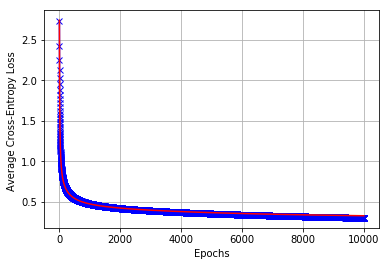

In [28]:
fig = plt.figure(1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Average Cross-Entropy Loss ')
plt.plot(range(len(train_epoch_loss_list)),train_epoch_loss_list, '-bx')
plt.plot(range(len(validation_epoch_loss_list)),validation_epoch_loss_list, '-r')

plt.show()

In [29]:
h2_values = sess.run(h2, feed_dict={x_ori:test_image_norm})

In [30]:
result_labels = np.zeros_like(h2_values,dtype=int)

In [31]:
result_labels[np.arange(len(h2_values)), h2_values.argmax(1)] = 1

In [32]:
result_labels = np.argmax(result_labels, axis=1)

In [33]:
from sklearn.metrics import f1_score

In [34]:
f1_score(test_labels,result_labels, average='micro')

0.8695999999999999

In [35]:
from pandas_ml import ConfusionMatrix

In [36]:
ConfusionMatrix(test_labels,result_labels)

Predicted     0    1     2     3     4    5    6     7     8    9  __all__
Actual                                                                    
0           831    0    15    41     3    2   97     0    11    0     1000
1             3  960     5    25     3    0    2     0     2    0     1000
2            15    2   789    15   103    1   70     0     5    0     1000
3            24   12    14   890    30    1   25     0     4    0     1000
4             0    0    97    34   808    0   55     0     6    0     1000
5             0    0     0     1     0  934    0    41     4   20     1000
6           134    1    99    36    74    1  637     0    18    0     1000
7             0    0     0     0     0   32    0   937     0   31     1000
8             2    1     7     7     3    5    8     5   962    0     1000
9             0    0     0     0     0    9    1    42     0  948     1000
__all__    1009  976  1026  1049  1024  985  895  1025  1012  999    10000